# --- Fairness & Explainability: setup --- #

**Цель ноутбука.** Оценить *справедливость* и качество модели, найти компромиссные пороги (в т.ч. пост-процессинг с FairLearn), проверить калибровку вероятностей по группам и объяснить поведение модели (SHAP или альтернативы).

1. Fairness-метрики: selection rate, TPR/FPR, precision, F1, dem. parity / equalized odds.
2. Пороговая оптимизация: скан порогов, Pareto (качество <-> разрыв справедливости), 'ThresholdOptimizer'.
3. Калибровка по группам: reliability curves.
4. Explainability: глобально (SHAP / permutation importance), локально (кейсы).

In [3]:
# --- Project paths bootstrip --- #

# imports & paths #
%load_ext autoreload
%autoreload 2

import sys
import scipy.sparse as sp
from pathlib import Path

# предоставление Jupyter доступа к модулям из корня проекта #
ROOT = Path.cwd()
while not any((ROOT / m).exists() for m in ('.git', 'pyproject.toml', 'README.md')) and ROOT.parent != ROOT:
    ROOT = ROOT.parent

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from paths import ROOT, DATA_DIR, RAW_DIR, INT_DIR, PROC_DIR, ART_DIR, REPORTS_DIR, MODELS_DIR, NB_DIR
print(f'[paths] ROOT = {ROOT}')

[paths] ROOT = C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02


In [25]:
# --- Fairness & Explainability: setup --- #

import warnings, logging, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

import shap
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix
)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline

from fairlearn.postprocessing import ThresholdOptimizer
from pandas.api.types import is_categorical_dtype


import inspect
import joblib, xgboost as xgb
from IPython import get_ipython
from pathlib import Path
from sklearn.inspection import permutation_importance
from joblib import load
from shutil import copy2
import re

# тихие режимы #
logging.getLogger('lightgbm').setLevel(logging.ERROR)
logging.getLogger('xgboost').setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*LightGBM binary classifier.*TreeExplainer.*')
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*Glyph .* missing from current font.*')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'DejaVu Sans'
rng = np.random.default_rng(42)

# подключение fairlearn (fairness-метрики и пост-процессинг) #
try:
    from fairlearn.metrics import (
        MetricFrame,
        selection_rate,
        demographic_parity_difference,
        demographic_parity_ratio,
        equalized_odds_difference
    )
    from fairlearn.postprocessing import ThresholdOptimizer
    FAIRLEARN_OK = True
except Exception as e:
    FAIRLEARN_OK = False
    warnings.warn('Fairlearn не найден - разделы MetricFrame/ThresholdOptimizer будут пропущены: {e}')

# подключение SHAP #
try:
    import shap
    SHAP_OK = True
except Exception:
    SHAP_OK = False
    warnings.warn('shap не найден - блоки с SHAP будут пропущены.')

# кривые калибровки #
from sklearn.calibration import calibration_curve

# общие настройки визуализации и воспроизводимости #
SEED = 42
rng = np.random.default_rng(SEED)

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True

# умный выбор директорий с артефактами и моделями #
def _first_existing(paths, fallback: Path):
    """Возвращает первый существующий путь из списка,
    иначе создает/возвращает fallback"""
    for p in paths:
        if p.exists():
            return p
    fallback.mkdir(parents=True, exist_ok=True)
    return fallback

CANDIDATE_ART_DIRS =    [ART_DIR]
CANDIDATE_MODEL_DIRS =  [MODELS_DIR]

ART_DIR = _first_existing(CANDIDATE_ART_DIRS, Path('artifacts'))
MODELS_DIR = _first_existing(CANDIDATE_MODEL_DIRS, Path('models'))

print('ART_DIR  =', ART_DIR.resolve())
print('MODELS_DIR  =', MODELS_DIR.resolve())
print('FAIRLEARN_OK:', FAIRLEARN_OK, '| SHAP_OK', SHAP_OK)

ImportError: cannot import name 'is_sparse_dtype' from 'pandas.api.types' (c:\Users\UserHome\miniconda3\envs\census_ds2\lib\site-packages\pandas\api\types\__init__.py)

In [5]:
# --- Notebook preamble: silence & style --- #

# тихие логгеры #
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('numba').setLevel(logging.ERROR)

# красивые графики и кириллица без предупреждений о 'glyphs' #
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# адресные централизованные фильтры предупреждений #
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*Numpy global RNG was seeded.*')
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*is_categorical_dtype is deprecated.*')
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*pandas.*allow_gtml.*')
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*FixedFormatter should only be used with FixedLocator.*')

# полностью скрыть DeprecationWarning #
warnings.filterwarnings('ignore', category=DeprecationWarning)

# без спама от Jupyter магии autereload #
ip = get_ipython()
if ip:
    try:
        ip.run_line_magic('load_ext', 'autoreload')
    except Exception:
        pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
model_path = MODELS_DIR / 'lgb_best.joblib'
if model_path.exists():
    lgb_best = load(model_path)
    print('Loaded model:', model_path)
else:
    lgb_best = None
    print('LGBM model not found:', model_path)

LGBM model not found: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\models\lgb_best.joblib


In [7]:
# --- Refresh fairlearn availability flags --- #

try:
    import fairlearn
    from fairlearn.metrics import (MetricFrame, selection_rate,
                                   demographic_parity_difference)
    from fairlearn.postprocessing import ThresholdOptimizer
    FAIRLEARN_OK = True
    THRESH_OPT_OK = True
    print('fairlearn OK:', fairlearn.__version__)
except Exception as e:
    FAIRLEARN_OK = False
    THRESH_OPT_OK = False
    print('[fairlearn] все еще недоступен. fairness-блоки будут пропущены: {e!r}')

fairlearn OK: 0.12.0.dev0


# --- Загрузка артефактов из 02_modeling.ipynb --- #

Берем сохраненные артефакты из 'notebooks/artifacts':
1. *'y_true_test.npy'*, *'y_pred_best.npy'*, *'y_proba_best.npy'*.
2. *'X_test_sesitive.csv'*.
3. *'feature_names_ater_preproc.csv'*.
4. *'results_df.csv'*.

Эти данные уже подготовлены и соответствуют лучшей модели.
Они нужны для оценки fairness, подбора порогов и объяснимости.

In [8]:
def must_exist(path: Path, hint: str = ""):
    """Бросает ошибку, если файл не найден"""
    if not path.exists():
        raise FileNotFoundError(f'Не найден файл: {path}. {hint}')

# пути #
p_y_true = ART_DIR / 'y_true_test.npy'
p_y_pred = ART_DIR / 'y_pred_best.npy'
p_y_proba = ART_DIR / 'y_proba_best.npy'
p_xsens = ART_DIR / 'X_test_sensitive.csv'
p_fnames = ART_DIR / 'feature_names_after_preproc.csv'
p_res = ART_DIR / 'results_df.csv'

# проверка наличия #
must_exist(p_y_true, 'Экспортируйте y_true_test.npy из 02_modeling.ipynb')
must_exist(p_y_pred, 'Экспортируйте y_pred_best.npy из 02_modeling.ipynb')
must_exist(p_y_proba, 'Экспортируйте y_proba_best.npy из 02_modeling.ipynb')
must_exist(p_xsens, 'Экспортируйте X_test_sensitive.csv из 02_modeling.ipynb')
must_exist(p_res, 'Экспортируйте results_df.csv из 02_modeling.ipynb')

# загрузка #
y_true_test = np.load(p_y_true)
y_pred_best = np.load(p_y_pred)
y_proba_best = np.load(p_y_proba)
X_test_sens = pd.read_csv(ART_DIR / 'X_test_sensitive.csv')

# feature_names могут отсутствовать (fallback: None) #
feature_names = None
if p_fnames.exists():
    try:
        feature_names = pd.read_csv(ART_DIR / 'feature_names_after_preproc.csv', header = None)[0].tolist()
    except Exception:
        feature_names = pd.read_csv(ART_DIR / 'fairness_results.csv').iloc[:, 0].tolist()

# результаты с информацией о моделях #
results_df = pd.read_csv(ART_DIR / 'results_df.csv')

print('Загружено:')
print('y_true_test  :', y_true_test.shape)
print('y_pred_best  :', y_pred_best.shape)
print('y_proba_best  :', y_proba_best.shape)
print('X_test_sens  :', X_test_sens.shape)
print('feature_names  :', len(feature_names) if feature_names else None)
print('results_df  :', results_df.shape)

Загружено:
y_true_test  : (9769,)
y_pred_best  : (9769,)
y_proba_best  : (9769,)
X_test_sens  : (9769, 4)
feature_names  : 116
results_df  : (7, 6)


In [9]:
# --- Загрузка лучшей модели --- #

best_model = None
bst = None

try:
    for fname in ['best_model.joblib', 'lgbm_best.joblib', 'rf_best,joblib', 'logreg_best.joblib']:
        cand = MODELS_DIR / fname
        if cand.exists():
            best_model = joblib.load(cand)
            print('Загружена модель:', cand.name)
            break

    cand_json = MODELS_DIR / 'XGB_es.json'
    if cand_json.exists():
        bst = xgb.Booster()
        bst.load_model(str(cand_json))
        print('Загружен XGB Booster:', cand_json.name)

except Exception as e:
    print('Не удалось загрузить модель:', e)

Загружена модель: lgbm_best.joblib


# --- sanity-check: размеры, NaN, распределение y_proba --- #

Проверяем:
1. Равную длину *'y_true_test'*, *'y_pred_best'*, *'y_proba_best'*, *'X_test_sens'*.
2. Отсутствие NaN в *'y_proba_best'* и корректный диапазон [0,1].
3. Быструю гистограмму *'y_proba_best'*.
4. Базовый pos_rate (t = 0.5) по ключевым группам ('sex', 'race', 'age_group', если есть).

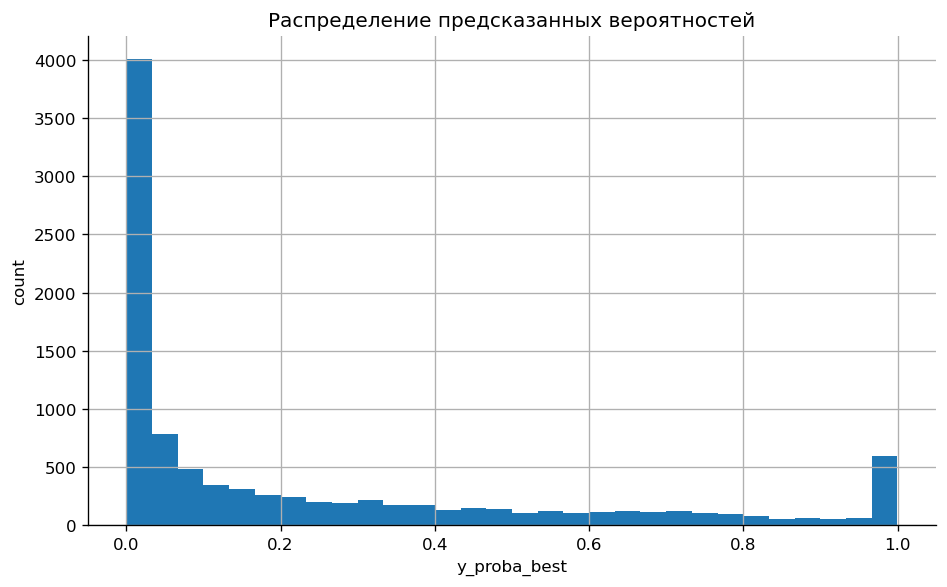

[sex] selection rate @ t = 0.5:
sex
Male      0.259722
Female    0.079659
Name: y_pred_05, dtype: float64 

[race] selection rate @ t = 0.5:
race
Asian-Pac-Islander    0.230263
White                 0.213584
Other                 0.086957
Black                 0.082627
Amer-Indian-Eskimo    0.076923
Name: y_pred_05, dtype: float64 

[age_group] selection rate @ t = 0.5:
age_group
46-65    0.316544
26-45    0.217785
65+      0.155125
18-25    0.007110
Name: y_pred_05, dtype: float64 



In [10]:
# --- sanity-check: размеры, NaN, распределение y_proba --- #

# согласованность размеров #
n = len(y_true_test)
assert len(y_pred_best) == n and len(y_proba_best) == n, 'Длины y_* не совпадают'
assert len(X_test_sens) == n, 'Длина X_test_sens не совпадает с y'

# NaN и допустимый диапазон #
assert np.isfinite(y_proba_best).all(), 'Есть NaN/Inf в y_proba_best'
assert (y_proba_best >= 0).all() and (y_proba_best <= 1).all(), 'y_proba_best вне [0,1]'

# гистограмма вероятностей #
plt.figure()
plt.hist(y_proba_best, bins=30)
plt.xlabel('y_proba_best')
plt.ylabel('count')
plt.title('Распределение предсказанных вероятностей')
plt.tight_layout()
plt.show()

# базовый pos_rate по группам (t = 0.5) #
t = 0.5
y_pred_05 = (y_proba_best >= t).astype('int8')

pred_ser = pd.Series(y_pred_05, index=X_test_sens.index, name='y_pred_05')

for gcol in [c for c in ['sex', 'race', 'age_group'] if c in X_test_sens.columns]:
    grp = X_test_sens[gcol].fillna('NA')
    rates = pred_ser.groupby(grp).mean().sort_values(ascending=False)
    print(f'[{gcol}] selection rate @ t = 0.5:')
    print(rates, '\n')

# --- Определение чувствительных признаков и групп --- #

Берем кандидатов ['sex', 'race', 'age_group'], оставляем только реаьно присутствующие в *'X_test_sens'*. Для каждого признака фиксируем список групп (без NaN), порядок - осмысленный (для *'age_group'* задаем категориальный порядок)

In [11]:
# --- Чувствительные признаки и группы --- #

CAND_SENSITIVE = ['sex', 'race', 'age_group']
SENSITIVE = [c for c in CAND_SENSITIVE if c in X_test_sens.columns]
print('Используем SENSITIVE:', SENSITIVE)

# осмысленный порядок для age_group #
if 'age_group' in SENSITIVE:
    desired_order = ['18-25', '26-45', '46-65', '65+']
    try:
        X_test_sens['age_group'] = pd.Categorical(
            X_test_sens['age_group'],
            categories=desired_order,
            ordered=True
        )
    except Exception as e:
        print('Не удалось задать порядок для age_group:', e)

# собираем уникальные значения по каждой чувствительной переменной #
GROUP_VALUES = {}
for col in SENSITIVE:
    vals = (
        X_test_sens[col]
        .dropna()
        .unique()
        .tolist()
    )
    if (col == 'age_group') and hasattr(X_test_sens[col], 'cat'):
        vals = [v for v in X_test_sens[col].cat.categories if v in set(X_test_sens[col].dropna())]
        GROUP_VALUES = list(vals)

# отчет по наличию групп и их размерам #
for col in SENSITIVE:
    print(f'\n[{col}] группы и размерности:')
    df_sizes = (
        X_test_sens[col]
        .value_counts(dropna=False)
        .rename_axis('group')
        .reset_index(name='n')
        .assign(share=lambda d: d['n'] / len(X_test_sens))
    )
    display(df_sizes)

print('\nGROUP_VALUES =', GROUP_VALUES)

# главная чувсвительная переменная  #
PRIMARY_SENS = SENSITIVE[0] if SENSITIVE else None
print('PRIMARY_SENS:', PRIMARY_SENS)

Используем SENSITIVE: ['sex', 'race', 'age_group']

[sex] группы и размерности:


,group,n,share
0,Male,6480,0.663323
1,Female,3289,0.336677



[race] группы и размерности:


,group,n,share
0,White,8348,0.854540
1,Black,944,0.096632
2,Asian-Pac-Islander,304,0.031119
3,Amer-Indian-Eskimo,104,0.010646
4,Other,69,0.007063



[age_group] группы и размерности:


,group,n,share
0,26-45,4858,0.497287
1,46-65,2581,0.264203
2,18-25,1969,0.201556
3,65+,361,0.036954



GROUP_VALUES = ['18-25', '26-45', '46-65', '65+']
PRIMARY_SENS: sex


# --- Базовая линия: метрики на общем пороге (0.5) --- #

Считаем Accuracy, F1, Precision, Recall, ROC-AUC на всем тестовом наборе при пороге 0.5.

In [12]:
# Базовые метрики на t = 0.5 #

# бинарные предсказания при пороге 0.5 #
y_pred_05 = (y_proba_best >= 0.5).astype(int)

base_metrics = {
    'accuracy': accuracy_score(y_true_test, y_pred_05),
    'f1': f1_score(y_true_test, y_pred_05),
    'precision': precision_score(y_true_test, y_pred_05, zero_division=0),
    'roc_auc': roc_auc_score(y_true_test, y_proba_best)
}

print('Базовые метрики (t = 0.5):')
display(pd.DataFrame([base_metrics]).round(4))

Базовые метрики (t = 0.5):


,accuracy,f1,precision,roc_auc
0,0.8789,0.7238,0.7969,0.9321


# --- Fairness по группам при t = 0.5 --- #

Считаем метрики по каждой чувствительной переменной:
1. *'selection_rate'* (доля позитивных предсказаний).
2. *'recall'* (TPR), *'FPR'*, *'precision'*, *'F1'*.
3. *'demographic_parity_difference'* / *'demographic_parity_ratio'*.
4. *'equalized_odds_difference'*.

In [13]:
# --- Групповые fairness-метрики при t = 0.5 --- #

t = 0.5
y_pred = (y_proba_best >= t).astype('int8')

def _prec(y_true, y_pred): return precision_score(y_true, y_pred, zero_devision=0)
def _rec(y_true, y_pred): return recall_score(y_true, y_pred, zero_division=0)
def _f1(y_true, y_pred): return f1_score(y_true, y_pred, zero_division=0)
def _acc(y_true, y_pred): return accuracy_score()

# --- Пороговая кривая и Pareto: качество vs Demographic Parity --- #

Перебираем пороги *'t ∈ [0.05; 0.95]'* с шагом 0.01. Для каждого t считаем:
1. общие метрики (accuracy, f1, precision, recall, roc_auc).
2. *'dp_diff_max'* - максимальный разрыв demographic parity среди всех чувствительных признаков.
3. *'eqodds_diff_max'* - максимальный разрыв equalized odds (через max по TPR/FPR).

Выбор t*: 0.94 при пороге fairness |DP diff|max <= 0.1


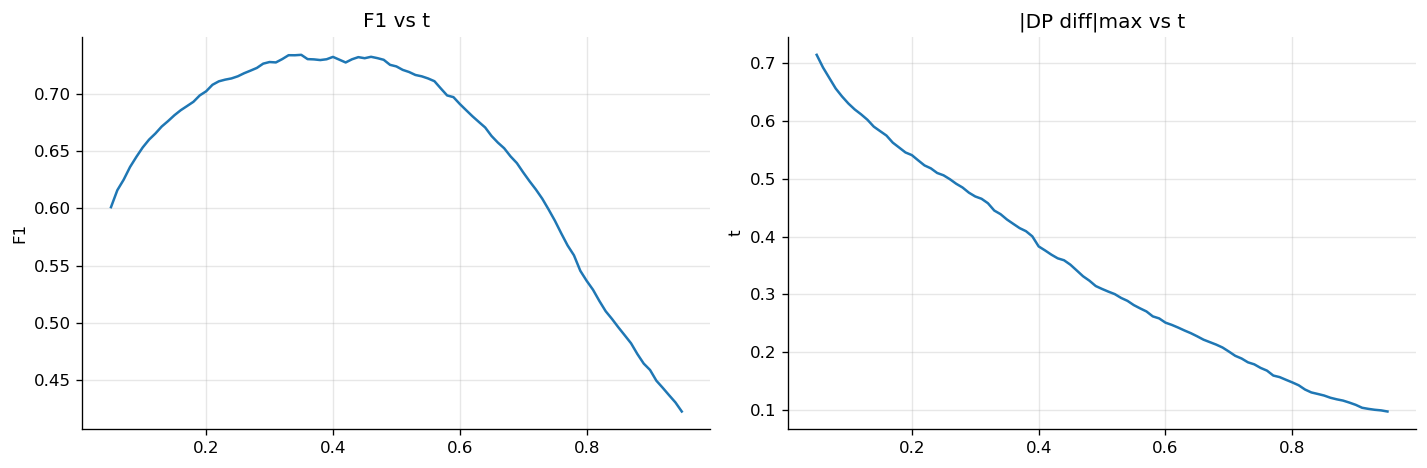

np.float64(0.94)

In [14]:
# --- Пороговый скан + Pareto + выбор t* --- #

# заполнение NaN в sens-серии #
def _sens_fill(s):
    s = s.copy()
    if is_categorical_dtype(s):
        if 'NA' not in s.cat.categories:
            s = s.cat.add_categories(['NA'])
        return s.fillna('NA')
    else:
        return s.fillna('NA')

sens_cols = [c for c in ['sex', 'race', 'age_group'] if c in X_test_sens.columns]

if len(sens_cols) == 0:
    print('Сенситивных признаков нет - t* = 0.5')
    t_star = 0.5
    scan_df = pd.DataFrame()
else:
    T = np.round(np.arange(0.05, 0.951, 0.01), 2)
    rows = []
    for t in T:
        y_pred_t = (y_proba_best >= t).astype('int8')
        # качество #
        row = {
            't': t,
            'f1': f1_score(y_true_test, y_pred_t, zero_division=0),
            'precision': precision_score(y_true_test, y_pred_t, zero_division=0),
            'recall': recall_score(y_true_test, y_pred_t, zero_division=0),
            'accuracy': accuracy_score(y_true_test, y_pred_t),
            'auc': roc_auc_score(y_true_test, y_proba_best)
        }
        # fairness: максимум |DP diff| по всем sens_cols #
        dp_abs = []
        for gcol in sens_cols:
            sf = _sens_fill(X_test_sens[gcol])
            dp = demographic_parity_difference(
                y_true=y_true_test,
                y_pred=y_pred_t,
                sensitive_features=sf
            )
            dp_abs.append(abs(dp))
        row['dp_diff_max'] = max(dp_abs) if dp_abs else 0.0
        rows.append(row)
    
    scan_df = pd.DataFrame(rows)

    # простая Pareto-эвристика: максимизация F1 при ограничении
    # |DP diff|max <= DELTA #
    DELTA = 0.10

    feasible_mask = scan_df['dp_diff_max'] <= DELTA
    feasible = scan_df.loc[feasible_mask]

    if not feasible.empty:
        t_star = feasible.sort_values(['f1', 'accuracy', 'recall'], ascending=False).iloc[0]['t']
        print(f'Выбор t*: {t_star:.2f} при пороге fairness |DP diff|max <= {DELTA}')
    else:
        t_star = 0.5
        print(f't с |DP diff|max <= {DELTA} не найден - fallback t* = 0.5')
    
# графики #
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(scan_df['t'], scan_df['f1']); ax[0].set_title('F1 vs t'); ax[0].set_ylabel('F1')
ax[1].plot(scan_df['t'], scan_df['dp_diff_max'].abs()); ax[1].set_title('|DP diff|max vs t'); ax[1].set_ylabel('t')
for a in ax: a.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

t_star

# --- Post-Processing: ThresholdOptimizer (DemographicParity / EqualizedOdds) --- #

Используем fairlearn.postprocessing.ThresholdOptimizer для подбора групповых порогов:
1. *'constraints=demographic_parity'* (DP).
2. *'constraints=equalized_odds'* (odds).

In [15]:
# --- Post‑processing: ThresholdOptimizer (DP / EqOdds) --- #

warnings.filterwarnings('ignore', category=UserWarning, message='.*sensitive features not unique.*')

# заполнение NaN в чувствительных признаках #
def _sens_fill(s):
    s = s.copy()
    if is_categorical_dtype(s):
        if 'NA' not in s.cat.categories:
            s = s.cat.add_categories(['NA'])
        return s.fillna('NA')
    else:
        return s.fillna('NA')

# выбор доступного чувствительного признака #
sens_cols = [c for c in ['sex', 'race', 'age_group'] if c in X_test_sens.columns]
if not sens_cols:
    print('Нет сенситивных признаков - пропуск ThresholdOptimizer')
else:
    gcol = 'sex' if 'sex' in X_test_sens.columns else sens_cols[0]
    sf = _sens_fill(X_test_sens[gcol])

    class _ScoresEstimator:
        """Суррогат-классификатор, который отдает уже посчитанные вероятности."""
        def __init__(self, scores):
            self.scores = np.asarray(scores)
            # чтобы check_fitted не ругался при prefit=True
            self.fitted_ = True

        def get_params(self, deep=True):
            return({'scores': self.scores})
        def set_params(self, **params):
            # запоминание размерности
            return self

        def fit(self, X, y):
            self.fitted_ = True
            # запоминание размерности
            return self
        
        def predict_proba(self, X):
            # X используется только для совместимости сигнатуры;
            # возвращаем заранее посчитанные вероятности
            p = self.scores
            return np.column_stack([1.0 - p, p])
    
    # создаем surrogate-модель и "признаки" как индексы #
    X_idx = np.arange(len(y_true_test)).reshape(-1, 1)
    base_est = _ScoresEstimator(y_proba_best)

    # ThresholdOptimizer под демографический паритет #
    postproc = ThresholdOptimizer(
        estimator=base_est,
        constraints='demographic_parity',
        predict_method='predict_proba',
        prefit=True
    )
    # fit/predict на одних и тех же X_idx #
    postproc.fit(X=X_idx, y=y_true_test, sensitive_features=sf)
    y_pred_dp = postproc.predict(X=X_idx, sensitive_features=sf).astype('int8')

    # метрики после пост-обработки #
    def _prec(y_true, y_pred): return precision_score(y_true, y_pred, zero_division=0)
    def _rec(y_true, y_pred): return recall_score(y_true, y_pred, zero_division=0)
    def _f1(y_true, y_pred): return f1_score(y_true, y_pred, zero_division=0)

    dp = demographic_parity_difference(y_true=y_true_test, y_pred=y_pred_dp, sensitive_features=sf)
    eq = equalized_odds_difference(y_true=y_true_test, y_pred=y_pred_dp, sensitive_features=sf)

    print(f'[ThresholdOptimizer @ {gcol}] '
          f'acc={accuracy_score(y_true_test, y_pred_dp):.3f} '
          f'f1={_f1(y_true_test, y_pred_dp):.3f} '
          f'prec={_prec(y_true_test, y_pred_dp):.3f} '
          f'rec={_rec(y_true_test, y_pred_dp):.3f} '
          f'| DP diff={dp:+.3f} EqOdds diff={eq:+.3f}'
    )

[ThresholdOptimizer @ sex] acc=0.855 f1=0.631 prec=0.805 rec=0.519 | DP diff=+0.000 EqOdds diff=+0.306


# --- Калибровка вероятностей по группам --- #

Строим кривые надежности (calibration curves) по ключевым группам и считаем простую ECE (Expected Calibration Error) по 10 бинам.


=== Calibration for sex ===


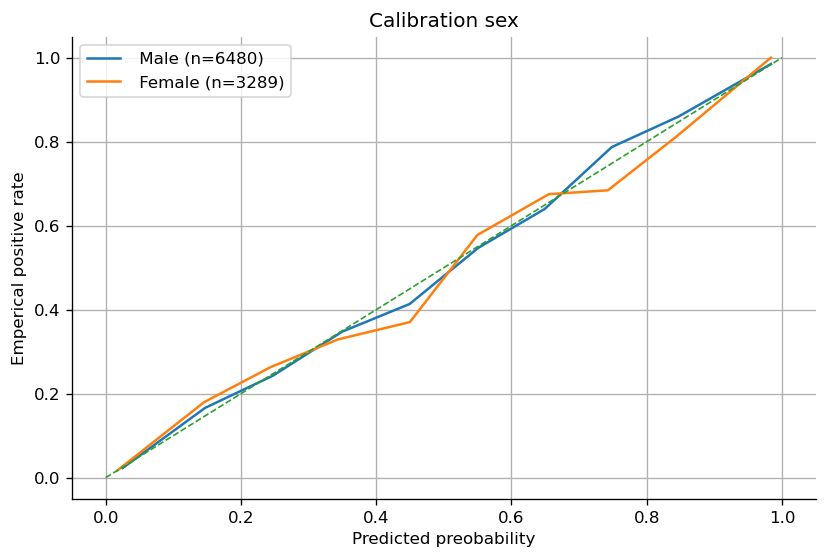

,group,n,ECE@10
1,Female,3289,0.006681
0,Male,6480,0.008409



=== Calibration for race ===


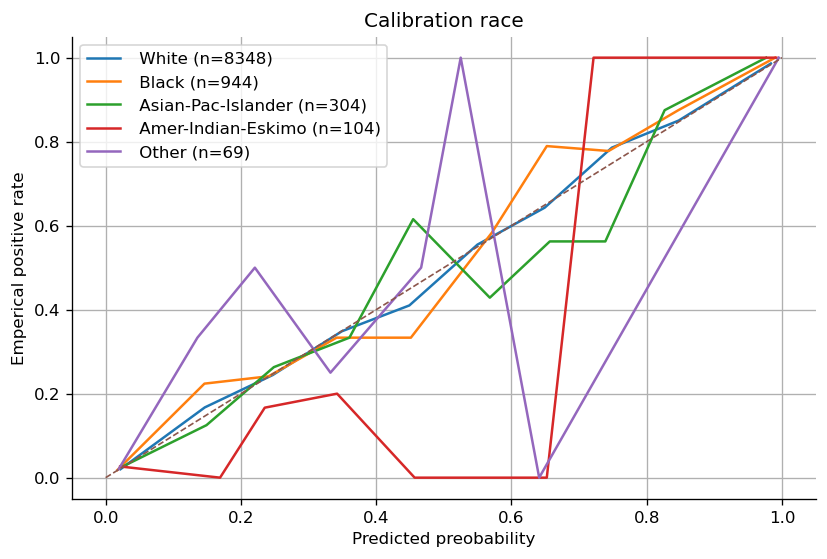

,group,n,ECE@10
0,White,8348,0.006972
2,Black,944,0.013674
3,Asian-Pac-Islander,304,0.033089
1,Other,69,0.047595
4,Amer-Indian-Eskimo,104,0.061997



=== Calibration for age_group ===


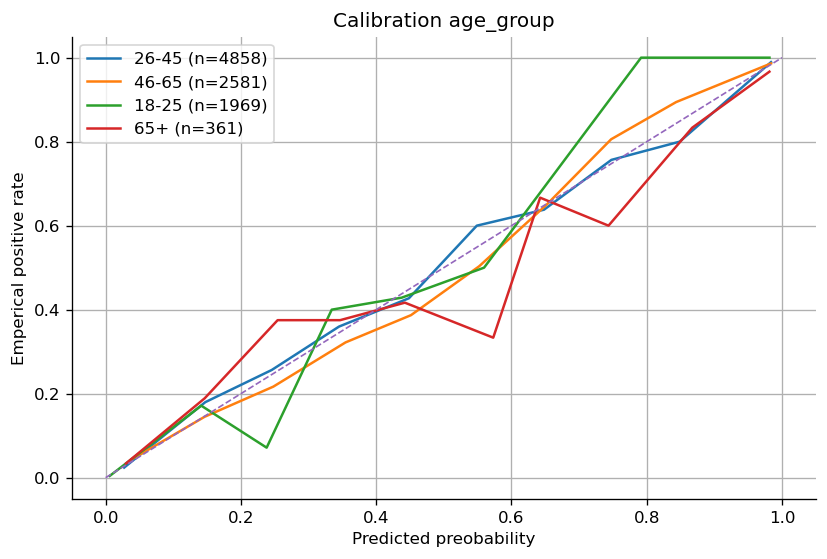

,group,n,ECE@10
2,18-25,1969,0.004333
0,26-45,4858,0.012147
1,46-65,2581,0.020697
3,65+,361,0.027683


In [16]:
def plot_reliability_by_groups(y_true, y_proba, group_series, n_bins=10, min_count=50, title=''):
    groups = group_series.value_counts().index.tolist()
    kept = []
    plt.figure()
    for g in groups:
        mask = (group_series == g).to_numpy()
        if mask.sum() < min_count:
            continue
        prob_true, prob_pred = calibration_curve(y_true[mask], y_proba[mask], n_bins=n_bins, strategy='uniform')
        plt.plot(prob_pred, prob_true, label=f'{g} (n={mask.sum()})')
        kept.append(g)
    plt.plot([0,1], [0,1], '--', linewidth=1)
    plt.xlabel('Predicted preobability')
    plt.ylabel('Emperical positive rate')
    plt.title(title or f'Calibration by {group_series.name}')
    if kept:
        plt.legend()
    plt.show()

def expected_calibration_error(y_true, y_proba, n_bins=10):
    """Простая ECE: средневзвешенная|emperical - predicted| по равным бинам вероятности."""
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    inds = np.digitize(y_proba, bins) - 1
    ece = 0.0
    total = len(y_true)
    for b in range(n_bins):
        mask = inds == b
        if not np.any(mask):
            continue
        p_hat = y_proba[mask].mean()
        p_emp = y_true[mask].mean()
        ece += (mask.sum() / total) * abs(p_emp - p_hat)
    return ece

candidate_sensitive = ['sex', 'race', 'age_group']
present_sensitive = [c for c in candidate_sensitive if c in X_test_sens.columns]

if not present_sensitive:
    print('Нет чувствительных колонок для калибровки.')
else:
    for col in present_sensitive:
        print(f'\n=== Calibration for {col} ===')
        plot_reliability_by_groups(
            y_true=y_true_test,
            y_proba=y_proba_best,
            group_series=X_test_sens[col],
            n_bins=10,
            min_count=50,
            title=f'Calibration {col}'
        )

        # ECE по группам (таблица) #
        rows = []
        for g in X_test_sens[col].dropna().unique():
            m = (X_test_sens[col] == g).to_numpy()
            if m.sum() < 50:
                continue
            ece = expected_calibration_error(y_true_test[m], y_proba_best[m], n_bins=10)
            rows.append({'group': g, 'n': int(m.sum()), 'ECE@10': float(ece)})
        if rows:
            df_ece = pd.DataFrame(rows).sort_values('ECE@10')
            display(df_ece)

In [17]:
# --- Loader: X_test_enc из artifacts --- #

p_npz = ART_DIR / 'X_test_enc.npz'
p_npy = ART_DIR / 'X_test_enc.npy'

if p_npz.exists():
    X_test_enc = sp.load_npz(p_npz)
    print('Loaded sparse:', p_npz, 'shape:', X_test_enc.shape)
elif p_npy.exists():
    X_test_enc = np.load(p_npy, allow_pickle=False)
    print('Loaded dense:', p_npy, 'shape:', X_test_enc.shape)
else:
    X_test_enc = None
    print('Внимание: X_test_enc.* не найден в artifacts (npz/npy). Продолжаем без него.')

Loaded sparse: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\artifacts\X_test_enc.npz shape: (9769, 115)


# --- Explainability: глобально (SHAP / альтернативы) --- #

Считаем SHAP:
1. Если есть *'bst'* (XGBoost Booster) и *'X_test_enc'* -> *'shap.TreeExplainer'*.
2. Иначе, если есть *'best_model'* (деревья/бустинг из sklearn/LightGBM) и *'X_test_enc'* -> тоже *'TreeExplainer'*.
3. Если SHAP недоступен -> fallback Permutation Importance (на *'X_test_enc'*).

[info] Переключение на модель под кэш: data\models\LGBM_best.joblib (features=116)
[info] Использование feature_names из: data\models\feature_names_116.txt
[info] feature_names сохранены в: data\models\feature_names_116.txt


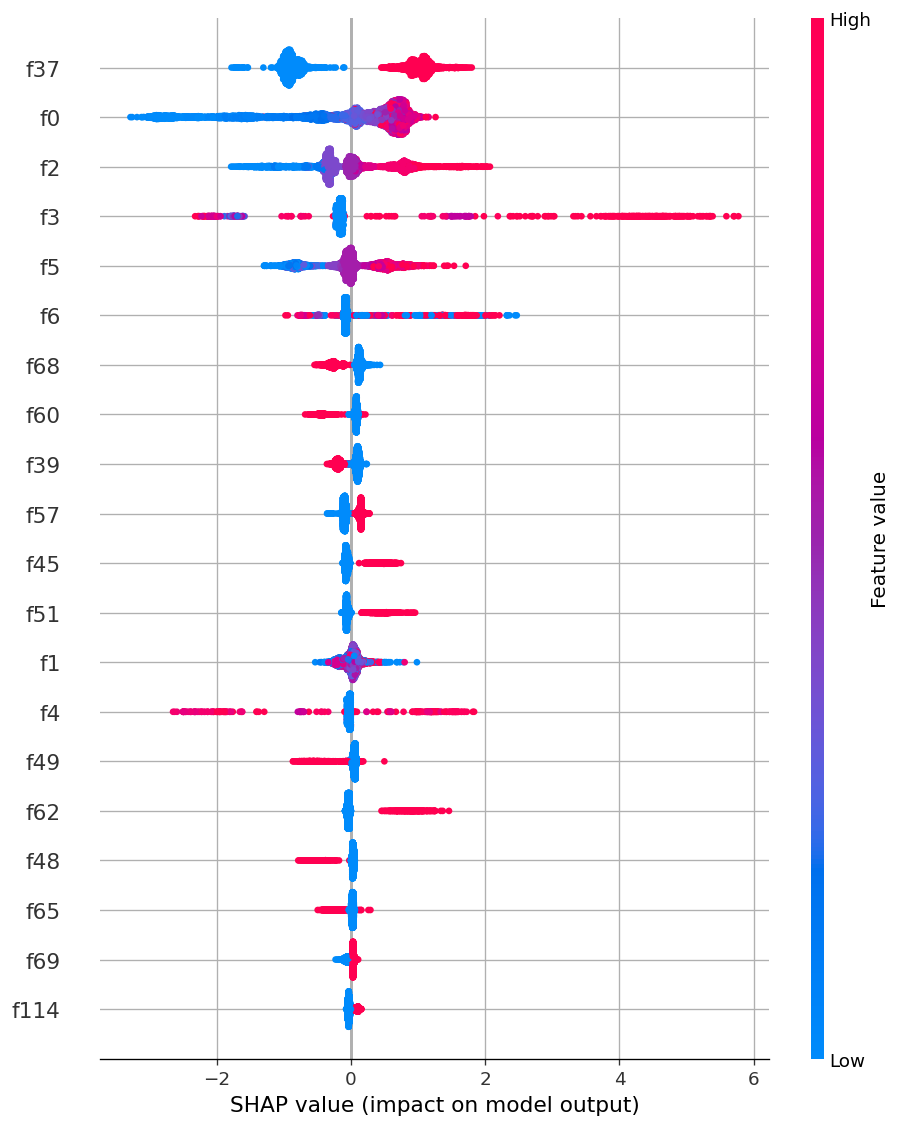

SHAP OK: LGBMClassifier | n=5000 | features=(5000, 116)


In [18]:
ART_DIR = Path('data') / 'models'

# поиск артефактов в проекте #
ART_DIRS = [
    Path('data') / 'artifacts',
    Path('data') / 'models',
    Path('notebooks') / 'artifacts',
    Path('notebooks') / 'models',
]

# рекурсивный поиск от нескольких корней #
SEARCH_ROOTS = [Path('.').resolve()]
SEARCH_ROOTS += list(SEARCH_ROOTS[0].parents)[:3]

def _walk_find(first_names_lower):
    """Рекурсивный поиск любого из файлов с именами из
    first_names_lower (lowercase)."""
    for root in SEARCH_ROOTS:
        if not root.exists():
            continue
        for p in root.rglob('*'):
            try:
                if p.is_file() and p.name.lower() in first_names_lower:
                    return p
            except PermissionError:
                continue
    return None

def _first_exists_any(names):
    """Вернуть первый существующий путь среди имен/шаблонов в любых ART_DIRS.
    names: список имен файлов (строки), поиск регистронезависимый."""
    names_lower = [n.lower() for n in names]
    for d in ART_DIRS:
        if not d.exists():
            continue
        for p in d.iterdir():
            if p.is_file() and p.name.lower() in names_lower:
                return p
    return _walk_find(names_lower)

def _first_exists_exact(relname):
    """
    Вернуть точный путь relname в первых существующих ART_DIRS.
    """
    for d in ART_DIRS:
        p = d / relname
        if p.exists():
            return p
    return None

pipe = None
clf = None
preproc = None

p_pipe = _first_exists_any(['model_best.joblib'])
if p_pipe is not None:
    pipe = load(p_pipe)
    preproc = pipe.named_steps.get('preproc', None)
    clf = pipe.named_steps.get('clf', None)

# fallback: если работали не pipeline #
if clf is None:
    p_model = _first_exists_any(['lgb_best.joblib', 'LGBM_best.joblib'])
    if p_model is not None:
        clf = load(p_model)

# подготовка XS (энкодированного теста) #
XS = None
feature_names = None

def _find_all_by_names(names):
    """
    Вернуть список путей ко всем файлам с именами из 'names' (регистронезависимо)
    в ART_DIRS и по всему дереву SEARCH_ROOTS (rglob).
    """
    names_lower = [n.lower() for n in names]
    found = []

    # прямой просмотр известных директорий #
    for d in ART_DIRS:
        try:
            if not d.exists():
                continue
            for p in d.iterdir():
                if p.is_file() and p.name.lower() in names_lower:
                    found.append(p)
        except Exception:
            continue

    # глубокий поиск от корней #
    for root in SEARCH_ROOTS:
        try:
            if not root.exists():
                continue
            for p in root.rglob('*'):
                try:
                    if p.is_file() and p.name.lower() in names_lower:
                        if p not in found:
                            found.append(p)
                except PermissionError:
                    continue
        except Exception:
            continue
    return found


def _scan_models():
    """
    Найти все доступные модели и вернуть список кортежей:
    (path, exp_n_features, model_obj)
    """
    candidates = _find_all_by_names(['model_best.joblib',
                                     'lgb_best.joblib', 'LGBM_best.joblib'])
    infos = []
    for p in candidates:
        try:
            m = load(p)
            n = _expected_n_features(m.named_steps['clf'] if hasattr(m, 'named_steps') else m)
            infos.append((p, n, m))
        except Exception:
            # пропуск несовместимых pickle
            continue
    return infos

def _maybe_switch_model_to_match(ncols):
    """
    Если текущая 'clf' не подходит по числу признаков и нет preproc,
    попробовать найти и загрузить модель, у которой exp_n == ncols.
    Возвращает путь к модели при успехе, иначе None.
    """
    global clf
    infos = _scan_models()
    for p, n, m in infos:
        if n is not None and n == ncols:
            clf = m
            print(f"[info] Переключение на модель под кэш: {p} (features={n})")
            return p
    return None

def _read_feature_names_from_file(p):
    """
    Прочитать список имен фич из txt/csv/json/parquet;
    вернуть list[str] или None.
    """
    try:
        sfx = p.suffix.lower()
        if sfx == '.txt':
            with open(p, 'r', encoding='utf-8') as f:
                return [line.strip() for line in f if line.strip() != '']
        if sfx == '.csv':
            df = pd.read_csv(p)
            # 1-я колонка как список, если единственная;
            # иначе - список колонок
            return df.iloc[:, 0].astype(str).tolist() if df.shape[1] == 1 else df.columns.astype(str).tolist()
        if sfx == '.json':
            import json
            with open(p, 'r', encoding='utf-8') as f:
                obj = json.load(f)
            # поддержка форматов: ['f1', 'f2', ...], {'feature_names': [...]} и т.п.
            if isinstance(obj, list):
                return [str(x) for x in obj]
            if isinstance(obj, dict):
                for k in ['feature_names', 'columns', 'names']:
                    if k in obj and isinstance(obj[k], list):
                        return [str(x) for x in obj[k]]
        if sfx == '.parquet':
            df = pd.read_parquet(p)
            return df.columns.astype(str).tolist()
    except Exception:
        return None
    return None

def _load_feature_names_best(n_expected):
    """
    Найти файл с именами признаков ровно на n_expected столбцов.
    Просмотр распространенных имен и расширений во всех ART_DIRS и SEARCH_ROOTS.
    """
    # наиболее вероятные имена файлов #
    name_variants = [
        f'feature_names_{n_expected}.txt',
        f'feature_names_{n_expected}.json',
        f'columns_{n_expected}.json',
        'feature_names.txt',
        'feature_names.json',
        'columns.json',
        'feature_names.csv',
        f'columns_{n_expected}.csv',
        f'feature_names_{n_expected}.csv',
        'X_test_columns.txt',
        'X_test_columns.json'
    ]
    # где искать #
    search_dirs = list(ART_DIRS)
    if 'SEARCH_ROOTS' in globals():
        for sroot in SEARCH_ROOTS:
            search_dirs += [
                sroot / 'data' / 'artifacts',
                sroot / 'data' / 'models',
                sroot / 'notebooks' / 'artifacts',
                sroot / 'notebooks' / 'models',
            ]
    # перебор кандидатов #
    tried = []
    for d in search_dirs:
        try:
            if not d.exists():
                continue
            for name in name_variants:
                p = d / name
                if not p.exists():
                    continue
                tried.append(str(p))
                names = _read_feature_names_from_file(p)
                if isinstance(names, list) and len(names) == n_expected:
                    print(f'[info] Использование feature_names из: {p}')
                    return names
        except Exception:
            continue
    if tried:
        print(f'[warn] Не найден файл с {n_expected} именами фич. Проверены: {tried}.')
    return None

def _align_feature_names_to_X(X_mat, feat_names):
    """Гарантированно вернуть список имен длиной X.shape[1]:
    поиск подходящего файла, иначе паддинг.
    """
    n_expected = X_mat.shape[1]
    # если есть и уже совпадает - возврат как есть #
    if isinstance(feat_names, list) and len(feat_names) == n_expected:
        return feat_names
    # попытка найти корректный файл #
    names = _load_feature_names_best(n_expected)
    if names is not None:
        return names
    # создание заглушки #
    print(f'[warn] feature_names отсутствуют или другой длины ({len(feat_names) if isinstance(feat_names, list) else None} vs {n_expected}). '
          f'Будут сгенерированы имена f0...f{n_expected-1}.')
    return [f'f{i}' for i in range(n_expected)]

def _reencode_from_raw(preproc_obj, art_dir=ART_DIR):
    """
    Перекодировать X_test из сырого вида через актуальный запрос.
    Источник №1 - объект в память (X_test_sens или X_test), если он есть.
    Источник №2 - файлы в ART_DIRS/SEARCH_ROOTS с разными расширениями.
    Результат сохраняем в data/models/X_test_enc.npz.
    """
    # попытка взять из памяти (глобальные переменные ноутбука) #
    X_raw = None
    try:
        if 'X_test_sens' in globals() and isinstance(globals()['X_test_sens'], pd.DataFrame):
            X_raw = globals()['X_test_sens'].copy()
        elif 'X_test' in globals() and isinstance(globals()['X_test'], pd.DataFrame):
            X_raw = globals()['X_test'].copy()
    except Exception:
        X_raw = None

    # если нет в памяти - расширенный поиск файлов-источников #
    if X_raw is None:
        # кандидаты путей/шаблонов (во всех ART_DIRS)
        cand_names = [
            'X_test_sensitive.csv', 'X_test_sensitive.parquet',
            'X_test_sensitive.feather', 'X_test.csv', 'X_test.parquet',
            'X_test.feather'
        ]
        candidates = []
        for root in ART_DIRS:
            for name in cand_names:
                candidates.append(root / name)
        
        # ищем глубже по SEARCH_ROOTS (на случай переноса)
        if 'SEARCH_ROOTS' in globals():
            for sroot in SEARCH_ROOTS:
                for name in cand_names:
                    candidates.append(sroot / 'data' / 'artifacts' / name)
                    candidates.append(sroot / 'data' / 'models' / name)
                    candidates.append(sroot / 'notebooks' / 'artifacts' / name)
                    candidates.append(sroot / 'notebooks' / 'models' / name)

        p_raw = next((p for p in candidates if p.exists()), None)
        if p_raw is None:
            raise RuntimeError(
                'Не найден источник X_test для перекодирования: ни объекта в памяти (X_test_sens/X_test), ' \
                'ни файлов (X_test_sensitive.* / X_test.*) в ART_DIRS/SEARCH_ROOTS.'
            )

        # чтение по расширению
        if str(p_raw).endswith('.csv'):
            X_raw = pd.read_csv(p_raw)
        elif str(p_raw).endswith('.parquet'):
            X_raw = pd.read_parquet(p_raw)
        elif str(p_raw).endswith('.feather'):
            import pyarrow.feather as feather
            X_raw = feather.read_feather(p_raw)
        else:
            raise RuntimeError(
                f'Неизвестный формат файла для X_test: {p_raw}'
            )

    # удаление целевой колонки #
    for tgt_col in ['target', 'income', 'y', 'label']:
        if tgt_col in X_raw.columns:
            X_raw = X_raw.drop(columns=[tgt_col])

    if preproc_obj is None:
        raise RuntimeError(
            'preproc не найден: нет возможности перекодировать X_test заново.'
        )
    
    XS_new = preproc_obj.transform(X_raw)

    # сохранение как .npz (csr) для единообразия #
    p_npz = art_dir / 'X_test_enc.npz'
    if hasattr(XS_new, 'tocsr'):
        sp.save_npz(p_npz, XS_new.tocsr())
    else:
        # numpy array -> в csr перед сохранением
        sp.save_npz(p_npz, sp.csr_matrix(XS_new))
    return XS_new

def _expected_n_features(clf_obj):
    """Вернуть ожидаемое число фичей модели."""
    if clf_obj is None:
        return None
    if hasattr(clf_obj, 'n_features_in_'):
        return int(clf_obj.n_features_in_)
    if hasattr(clf_obj, 'booster_') and clf_obj.booster_ is not None:
        try:
            return int(clf_obj.booster_.num_feature())
        except Exception:
            pass
    return None

def _load_X_test_enc_any():
    # быстрые стандартные пути в ART_DIR #
    p_npz = ART_DIR / 'X_test_enc.npz'
    p_npy = ART_DIR / 'X_test_enc.npy'
    p_par = ART_DIR / 'X_test_enc.parquet'

    XS_local = None
    if p_npz.exists():
        XS_local = sp.load_npz(p_npz)
    elif p_par.exists():
        XS_local = pd.read_parquet(p_par)
    elif p_npy.exists():
        XS_local = np.load(p_npy, allow_pickle=False)
    
    # если в ART_DIR нет - поиск кэша по всему проекту #
    if XS_local is None:
        cache_paths = _find_all_by_names(
            ['X_test_enc.npz', 'X_test_enc.parquet', 'X_test_enc.npy']
        )
        for p in cache_paths:
            try:
                if str(p).endswith('.npz'):
                    XS_local = sp.load_npz(p)
                elif str(p).endswith('.parquet'):
                    XS_local = pd.read_parquet(p)
                elif str(p).endswith('.npy'):
                    XS_local = np.load(p, allow_pickle=False)
                if XS_local is not None:
                    print(f'[info] Найден кэш X_test_enc: {p}')
                    break
            except Exception:
                continue
        
    # если нет кэша вообще - только тогда перекодировка, если есть preproc #
    if XS_local is None:
        return _reencode_from_raw(preproc)
    
    # приведение к формату для LightGBM #
    if isinstance(XS_local, pd.DataFrame):
        XS_local = XS_local.values
    
    # сверка числа фич с моделью; сначала попытка подобрать кэш нужной ширины, #
    # а перекодировка только если есть preproc #
    exp_n = _expected_n_features(clf)
    if exp_n is not None:
        cur_n = XS_local.shape[1] if len(XS_local.shape) == 2 else None
        if (cur_n is not None) and (cur_n != exp_n):
            
            if preproc is not None:
                print(f'[warn] X_test_enc shape mismatch: {cur_n} vs {exp_n}. Перекодировка через актуальный preproc...')
                XS_local = _reencode_from_raw(preproc)
                if isinstance(XS_local, pd.DataFrame):
                    XS_local = XS_local.values
                # повторная сверка
                cur_n = XS_local.shape[1]
                if cur_n != exp_n:
                    raise RuntimeError(
                        f'После перекодирования размерность все еще {cur_n}, ожидалось {exp_n}.'
                    )
                return XS_local

            # 4B) preproc отсутствует: пробуем подобрать КЭШ под модель
            #     (вдруг где-то есть кэш с нужной шириной)
            found_shapes = []
            cache_paths_all = _find_all_by_names(['X_test_enc.npz', 'X_test_enc.parquet', 'X_test_enc.npy'])
            matched_cache = None
            for p in cache_paths_all:
                try:
                    if str(p).endswith('.npz'):
                        X_tmp = sp.load_npz(p)
                    elif str(p).endswith('.parquet'):
                        X_tmp = pd.read_parquet(p)
                    elif str(p).endswith('.npy'):
                        X_tmp = np.load(p, allow_pickle=False)
                    else:
                        continue
                    ncols = X_tmp.shape[1] if len(X_tmp.shape) == 2 else None
                    found_shapes.append((str(p), ncols))
                    if ncols == exp_n:
                        XS_local = X_tmp if not isinstance(X_tmp, pd.DataFrame) else X_tmp.values
                        matched_cache = p
                        print(f"[info] Используем кэш, совпадающий с моделью: {matched_cache}")
                        return XS_local
                except Exception:
                    continue

            # 4C) не нашли кэш под модель — пробуем наоборот: выбрать модель под уже найденный кэш
            switched = _maybe_switch_model_to_match(cur_n)
            if switched is not None:
                # модель теперь совпадает с XS_local
                return XS_local

            # 4D) ни кэша под модель, ни модели под кэш — даём развёрнутую подсказку
            raise RuntimeError(
                "[shape mismatch] Совместимая пара (модель ↔ кэш X_test_enc) не найдена.\n"
                f"  - ширина текущей модели: {exp_n}\n"
                f"  - ширина найденного кэша: {cur_n}\n"
                f"  - попробуйте: (1) подключить pipeline model_best.joblib (будет preproc для перекодировки), "
                "(2) положить кэш X_test_enc.* с нужной шириной под модель, "
                "(3) или использовать модель, совпадающую по числу признаков с уже найденным кэшем."
            )

    return XS_local

XS = _load_X_test_enc_any()

# приведение XS к допустимому формату #
if isinstance(XS, pd.DataFrame):
    # избавление от индексов/имен столбцов
    XS = XS.values

# feature_names: добыть и зафиксировать без предупреждений #
def _booster_feature_names_or_none(clf_obj, n_expected):
    try:
        if hasattr(clf_obj, 'booster_') and clf_obj.booster_ is not None:
            names = list(clf_obj.booster_.feature_name())
            if isinstance(names, list) and len(names) == n_expected:
                # игнор дефолтных f0..fN
                if all(isinstance(x, str) and re.fullmatch(r'f\d+', x) for x in names):
                    return None
                return [str(x) for x in names]
    except Exception:
        pass
    return None

ncols = XS.shape[1]

# попытка взять имена из booster (если не f0..) #
feature_names = _booster_feature_names_or_none(clf, ncols)

# если из booster не получилось - поиск файлов с именами #
if feature_names is None:
    feature_names = _load_feature_names_best(ncols)

# если все равно нет - синтез и сохранение на диск, во избежание [warn] #
if not isinstance(feature_names, list) or len(feature_names) != ncols:
    feature_names = [f'f{i}' for i in range(ncols)]
    try:
        ART_DIR.mkdir(parents=True, exist_ok=True)
        out_txt = ART_DIR / f'feature_names_{ncols}.txt'
        with open(out_txt, 'w', encoding='utf-8') as f:
            for c in feature_names:
                f.write(c + '\n')
        print(f'[info] Сгенерированы и сохранены feature_names: {out_txt}')
    except Exception:
        pass

# формирование DataFrame #
if sp.issparse(XS):
    XS = pd.DataFrame.sparse.from_spmatrix(
        XS, columns=feature_names
    )
else:
    XS = pd.DataFrame(
        XS, columns=feature_names
    )

# опционально: фиксация согласованных имен на будущее #
try:
    out_txt = ART_DIR / f'feature_names_{XS.shape[1]}.txt'
    with open(out_txt, 'w', encoding='utf-8') as f:
        for c in feature_names:
            f.write(str(c) + '\n')
    print(f'[info] feature_names сохранены в: {out_txt}')
except Exception:
    pass

# проверки #
if clf is None:
    found_models = [p for p in ['model_best.joblib', 'lgb_best.joblib', 'LGBM_best.joblib'] if _first_exists_any([p]) is not None]
    raise RuntimeError(f'Нет модели для SHAP (ни pipeline, ни lgb_best). Экспортируйте из 02_modeling.ipynb '
                       f'Найдено моделей: {found_models or "нет"}.')

if XS is None:
    found_X = [p for p in ['X_test_enc.npz' ,'X_test_enc.parquet', 'X_test_enc.npy'] if _first_exists_exact(p) is not None]
    raise RuntimeError(f'Нет X_test_enc для SHAP. Проверьте экспорт из 02_modeling.ipynb '
                       f'Найдены: {found_X or "нет"}.')


# подвыборка #
N = min(5000, len(XS))
idxs = rng.choice(len(XS), size=N, replace=False)
XS_sample = XS.iloc[idxs] if hasattr(XS, 'iloc') else XS[idxs, :]

# гарантия попадания в explainer классификатора, а не pipeline #
def _extract_model(obj):
    """Вернуть конечную модель из sklearn.Pipeline или сам obj,
    если он уже модель."""
    if obj is None:
        return None
    if isinstance(obj, Pipeline) or hasattr(obj, 'named_steps'):
        steps = getattr(obj, 'named_steps', {})
        mdl = steps.get('clf', None)
        if mdl is None:
            for _, step in steps.items():
                if hasattr(step, 'predict_proba') or hasattr(step, 'predict'):
                    mdl = step
                    break
        return mdl
    return obj

# приоритет: явный clf -> извлеченный из pipe -> извлеченный из clf, #
# если это pipeline #
clf_for_shap = None
if clf is not None:
    clf_for_shap = _extract_model(clf)
if clf_for_shap is None and pipe is not None:
    clf_for_shap = _extract_model(pipe)

# финальная валидация #
if clf_for_shap is None or isinstance(clf_for_shap, Pipeline):
    raise RuntimeError(
        'Не удалось выделит поддерживаемую модель для SHAP (получени None/Pipeline). ' \
        'Убедитесь, что загружается именно LGBMClassifier (например, lgb_best.joblib), ' \
        'или файл model_best.joblib содержит шаг "clf"'
    )

# explain #
expl = shap.TreeExplainer(clf_for_shap)
shap_vals = expl.shap_values(XS_sample)

# бинарный класс -> берем вклад позитивного класса #
if isinstance(shap_vals, list):
    try:
        classes_ = getattr(clf_for_shap, 'classes_', [0, 1])
        pos_idx = list(classes_).index(1)
    except Exception:
        pos_idx = 1 if len(shap_vals) > 1 else 0
    shap_vals_pos = shap_vals[pos_idx]
else:
    shap_vals_pos = shap_vals

shap.summary_plot(shap_vals_pos, XS_sample, show=False)
plt.tight_layout(); plt.show()
print(f'SHAP OK: {type(clf_for_shap).__name__} | n={N} | features={XS_sample.shape}')

In [19]:
# --- Закрепление совместимых пар артефактов --- #

ART_DIR.mkdir(parents=True, exist_ok=True)

# модель #
src_model = _first_exists_any(
    ['model_best.joblib', 'LGBM_best.joblib', 'lgb_best.joblib']
)
if src_model is not None:
    dst_model = ART_DIR / src_model.name
    
    try:
        same = src_model.resolve() == dst_model.resolve()
    except Exception:
        same = str(src_model) == str(dst_model)
    
    if same:
        print(f'[info] Модель уже находится в целевой директории: {dst_model}')
    elif dst_model.exists():
        print(f'[info] Модель уже закреплена: {dst_model}')
    else:
        copy2(src_model, dst_model)
        print(f'[info] Модель скопирована в: {dst_model}')
else:
    print('[warn] Не найден ни один файл модели среди: model_best.joblib / LGBM_best.joblib / lgb_best.joblib')

# кэш X_test_enc #
src_xs = _first_exists_any(
    ['X_test_enc.npz', 'X_test_enc.parquet', 'X_test_enc.npy']
)
if src_xs is not None:
    dst_xs = ART_DIR / src_xs.name

    # нормализация и проверяем "тот же файл"
    try:
        same = src_xs.resolve() == dst_xs.resolve()
    except Exception:
        same = str(src_xs) == str(dst_xs)

    if same:
        print(f'[info] X_test_enc уже находится в целевой директории: {dst_xs}')
    elif dst_xs:
        print(f'[info] X_test_enc уже закреплен: {dst_xs}')
    else:
        copy2(src_xs, dst_xs)
        print(f'[info] X_test_enc скопирован в: {dst_xs}')
else:
    print('[warn] Не найден ни один кэш X_test_enc.* для закрепления.')

[info] Модель уже находится в целевой директории: data\models\LGBM_best.joblib
[info] X_test_enc уже находится в целевой директории: data\models\X_test_enc.npy


In [20]:
for d in ['data/models', 'data/artifacts', 'notebooks/models', 'notebooks/artifacts']:
    if os.path.exists(d):
        print(d, os.listdir(d))

data/models ['feature_names_116.txt', 'LGBM_best.joblib', 'X_test_enc.npy']


[info] feature_names загружены из: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\artifacts\feature_names.npy
[info] feature_names взяты из модели (booster).


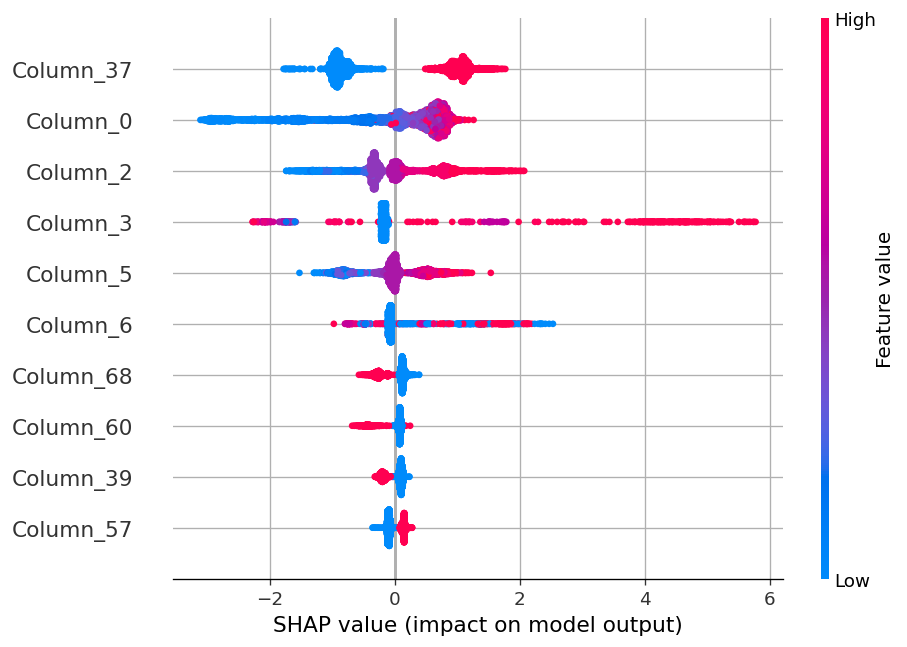

In [21]:
# --- Dependence-plots для топ-фич --- #

# поиск артефактов во всех типичных папках проекта #
ART_DIRS = [
    Path('data') / 'artifacts',
    Path('data') / 'models',
    Path('notebooks') / 'artifacts',
    Path('notebooks') / 'models',
]

def _first_exists_any(names):
    names_lower = [n.lower() for n in names]
    for d in ART_DIRS:
        if not d.exists():
            continue
        for p in d.iterdir():
            if p.is_file() and p.name.lower() in names_lower:
                return p
    # рекурсивный fallback #
    roots = [Path('.').resolve()]
    roots += list(roots[0].parents)[:3]
    for root in roots:
        for p in root.rglob('*'):
            try:
                if p.is_file() and p.name.lower() in names_lower:
                    return p
            except PermissionError:
                continue
    return None

# модель #
clf = None
p_model = _first_exists_any(['lgb_best.joblib', 'LGBM_best.joblib', 'model_best.joblib'])
if p_model is not None:
    obj = load(p_model)
    # если это pipeline — достанем из него clf #
    if hasattr(obj, 'named_steps'):
        clf = obj.named_steps.get('clf', None) or obj
    else:
        clf = obj

# данные: X_test_enc + feature_names #
XS = None
feature_names = None

def _load_X_test_enc_any():
    """
    Универсальный загрузчик X_test_enc:
      1) если в памяти уже есть XS — вернуть его;
      2) искать кэш в «точных» путях, затем по расширенному поиску;
      3) нормализовать тип (DataFrame -> ndarray);
      4) сверить число признаков с моделью; при несовпадении:
         - подобрать кэш с нужной шириной;
         - если есть preproc — перекодировать из сырого;
         - иначе — дать понятную ошибку.
    Требует функций _first_exists_exact, _first_exists_any, _expected_n_features,
    а для перекодирования — _reencode_from_raw (если preproc не None).
    """
    # 0) уже загружено в памяти?
    try:
        if 'XS' in globals() and globals()['XS'] is not None:
            return globals()['XS']
    except Exception:
        pass

    XS_local = None

    # 1) точные пути
    for fname in ['X_test_enc.npz', 'X_test_enc.parquet', 'X_test_enc.npy']:
        p = _first_exists_exact(fname)
        if p is None:
            continue
        if p.suffix == '.npz':
            XS_local = sp.load_npz(p)
        elif p.suffix == '.parquet':
            XS_local = pd.read_parquet(p)
        elif p.suffix == '.npy':
            XS_local = np.load(p, allow_pickle=False)
        if XS_local is not None:
            break

    # 2) расширенный поиск
    if XS_local is None:
        for fname in ['X_test_enc.npz', 'X_test_enc.parquet', 'X_test_enc.npy']:
            p = _first_exists_any([fname])
            if p is None:
                continue
            if p.suffix == '.npz':
                XS_local = sp.load_npz(p)
            elif p.suffix == '.parquet':
                XS_local = pd.read_parquet(p)
            elif p.suffix == '.npy':
                XS_local = np.load(p, allow_pickle=False)
            if XS_local is not None:
                break

    if XS_local is None:
        return None

    # 3) нормализация типа
    if isinstance(XS_local, pd.DataFrame):
        XS_local = XS_local.values

    # 4) сверка числа фич с моделью
    exp_n = _expected_n_features(clf) if 'clf' in globals() else None
    if exp_n is not None and hasattr(XS_local, 'shape'):
        cur_n = XS_local.shape[1] if len(XS_local.shape) == 2 else None
        if (cur_n is not None) and (cur_n != exp_n):
            # 4A) попробовать подобрать другой кэш с нужной шириной
            found_shapes = []
            matched = None
            for fname in ['X_test_enc.npz', 'X_test_enc.parquet', 'X_test_enc.npy']:
                p = _first_exists_any([fname])
                if p is None:
                    continue
                try:
                    if p.suffix == '.npz':
                        X_tmp = sp.load_npz(p)
                    elif p.suffix == '.parquet':
                        X_tmp = pd.read_parquet(p)
                    elif p.suffix == '.npy':
                        X_tmp = np.load(p, allow_pickle=False)
                    else:
                        continue
                    ncols = X_tmp.shape[1] if len(X_tmp.shape) == 2 else None
                    found_shapes.append((str(p), ncols))
                    if ncols == exp_n:
                        matched = X_tmp if not isinstance(X_tmp, pd.DataFrame) else X_tmp.values
                        break
                except Exception:
                    continue
            if matched is not None:
                return matched

            # 4B) если есть preproc — перекодируем корректно
            if 'preproc' in globals() and preproc is not None:
                XS_new = _reencode_from_raw(preproc)
                if isinstance(XS_new, pd.DataFrame):
                    XS_new = XS_new.values
                if XS_new.shape[1] != exp_n:
                    raise RuntimeError(
                        f"После перекодирования размерность всё ещё {XS_new.shape[1]}, ожидалось {exp_n}."
                    )
                return XS_new

            # 4C) иначе — понятная подсказка
            raise RuntimeError(
                "[shape mismatch] Число признаков X_test_enc не совпадает с моделью, "
                "соответствующий кэш не найден, а preproc отсутствует. "
                "Добавьте pipeline (model_best.joblib) или используйте модель, согласованную с имеющимся кэшем."
            )

    return XS_local


XS = _load_X_test_enc_any()

# загрузка feature_names из артефактов #
feature_names = None
for nm in [
    'feature_names.npy', 'feature_names.txt', 'feature_names.json',
    'feature_names.csv', 'feature_names.parquet'
]:
    p = _first_exists_any([nm])
    if p is None:
        continue
    try:
        sfx = p.suffix.lower()
        if sfx == '.npy':
            try:
                arr = np.load(p, allow_pickle=False)
            except ValueError:
                # файл сохранен как object-массив -> требуется pickle
                arr = np.load(p, allow_pickle=True)
            feature_names = list(map(str, np.asarray(arr).ravel().tolist()))
        elif sfx == '.txt':
            with open(p, 'r', encoding='utf-8') as f:
                feature_names = [line.strip() for line in f if line.strip() != '']
        elif sfx == '.json':
            import json
            with open(p, 'r', encoding='utf-8') as f:
                obj = json.load(f)
            if isinstance(obj, list):
                feature_names = [str(x) for x in obj]
            elif isinstance(obj, dict):
                for k in ['feature_names', 'columns', 'names']:
                    if k in obj and isinstance(obj[k], list):
                        feature_names = [str(x) for x in obj[k]]
                        break
        elif sfx == '.csv':
            df = pd.read_csv(p)
            feature_names = df.iloc[:, 0].astype(str).tolist() if df.shape[1] == 1 else df.columns.astype(str).tolist()
        elif sfx == '.parquet':
            df = pd.read_parquet(p)
            feature_names = df.columns.astype(str).tolist()
    except Exception:
        feature_names = None
    if feature_names:
        print(f'[info] feature_names загружены из: {p}')
        break  

# выравнивание feature_names под текущую матрицу XS #
ncols = XS.shape[1]

# попытка взять имена из модели (если не дефолтные f0..fN) #
try:
    if 'clf' in globals() and clf is not None and hasattr(clf, 'booster_') and clf.booster_ is not None:
        fnm = list(clf.booster_.feature_name())
        all_fnums = all(isinstance(x, str) and re.fullmatch(r'f\d+', x) for x in fnm)
        if isinstance(fnm, list) and len(fnm) == ncols and not all_fnums:
            feature_names = [str(x) for x in fnm]
            print('[info] feature_names взяты из модели (booster).')
except Exception:
    pass

# гарантия совпадения длины: обрезать/дополнить при необходимости #
def _ensure_len(cols, n):
    lst = list(cols) if isinstance(cols, (list, np.ndarray, pd.Index)) else []
    if len(lst) == n:
        return [str(c) for c in lst]
    if len(lst) > n:
        print(f'[warn] feature_names длиннее ({len(lst)}) ncols={n}. Обрезаем.')
        return [str(c) for c in lst[:n]]
    print(f'[warn] feature_names короче ({len(lst)}) ncols={n}. Дополняем f{len(lst)}..f{n-1}.')
    return [str(c) for c in (lst + [f'f{i}' for i in range(len(lst), n)])]

if (feature_names is None) or (isinstance(feature_names, (list, np.ndarray, pd.Index)) and len(feature_names) != ncols):
    feature_names = _ensure_len(feature_names, ncols)


if XS is not None and not isinstance(XS, pd.DataFrame):
    if sp.issparse(XS):
        XS = pd.DataFrame.sparse.from_spmatrix(XS, columns=(feature_names if feature_names is not None else None))
    else:
        XS = pd.DataFrame(XS, columns=(feature_names if feature_names is not None else None))

# выделение классификатора из pipeline при необходимости #
clf_for_shap = None
if 'clf' in globals() and clf is not None and hasattr(clf, 'predict_proba'):
    clf_for_shap = clf
elif 'pipe' in globals() and hasattr(pipe, 'named_steps'):
    clf_for_shap = pipe.named_steps.get('clf', None)
    if clf_for_shap is None:
        for _, step in pipe.named_steps.items():
            if hasattr(step, 'predict_proba') or hasattr(step, 'predict'):
                clf_for_shap = step
                break

# единая проверка и подвыборка #
if clf_for_shap is None or XS is None:
    print('Нет пригодной модели/данных для SHAP: пропуск dependence-plots.')
else:
    # подвыборка
    idx = np.arange(len(XS))
    if len(idx) > 5000:
        idx = rng.choice(idx, size=5000, replace=False)
    XS_sub = XS.iloc[idx] if hasattr(XS, 'iloc') else XS[idx, :]

    expl = shap.TreeExplainer(clf_for_shap)
    shap_vals = expl.shap_values(XS_sub)

    # бинарный класс -> берем вклад позитивного класса #
    if isinstance(shap_vals, list):
        try:
            classes_ = getattr(clf_for_shap, 'classes_', [0, 1])
            pos_idx = list(classes_).index(1)
        except Exception:
            pos_idx = 1 if len(shap_vals) > 1 else 0
        shap_vals = shap_vals[pos_idx]

    # top-k #
    topk = 10
    shap.summary_plot(
        shap_vals, XS_sub,
        feature_names=(feature_names if feature_names is not None else None),
        show=False, max_display=topk
    )
    plt.tight_layout(); plt.show()

[warn] row idx=6379: добавлены 1 нулевых столбцов (cur=115, exp=116).
[warn] feature_names короче (115) ncols=116. Дополняем f115..f115.


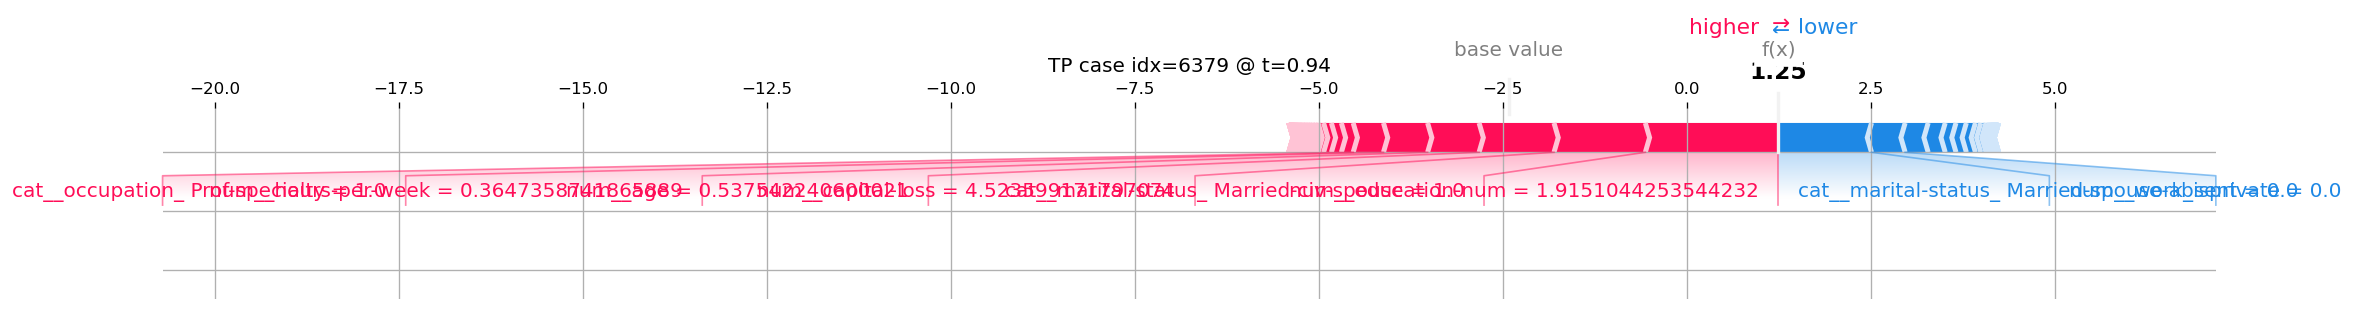

[warn] row idx=968: добавлены 1 нулевых столбцов (cur=115, exp=116).
[warn] feature_names короче (115) ncols=116. Дополняем f115..f115.


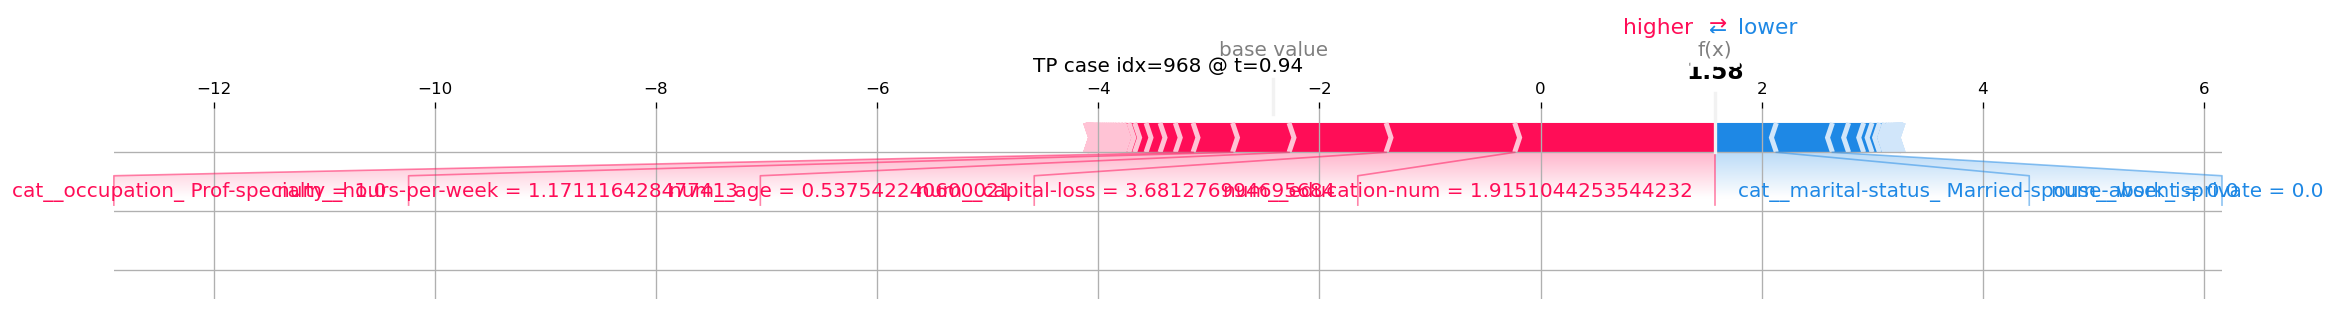

[warn] row idx=7511: добавлены 1 нулевых столбцов (cur=115, exp=116).
[warn] feature_names короче (115) ncols=116. Дополняем f115..f115.


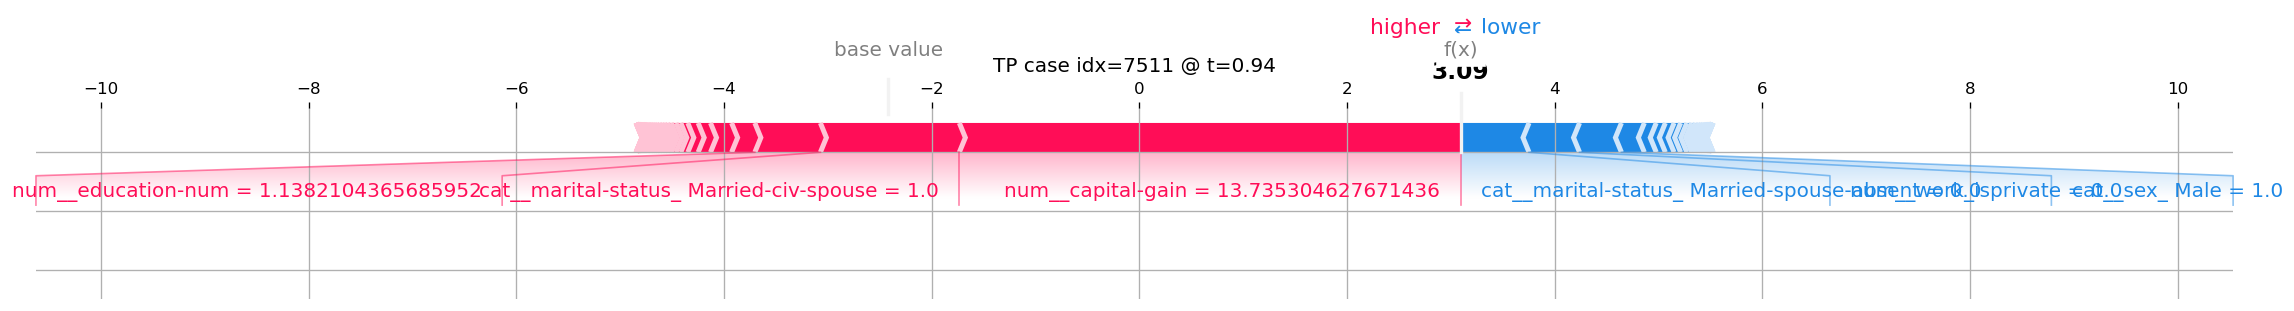

[warn] row idx=4854: добавлены 1 нулевых столбцов (cur=115, exp=116).
[warn] feature_names короче (115) ncols=116. Дополняем f115..f115.


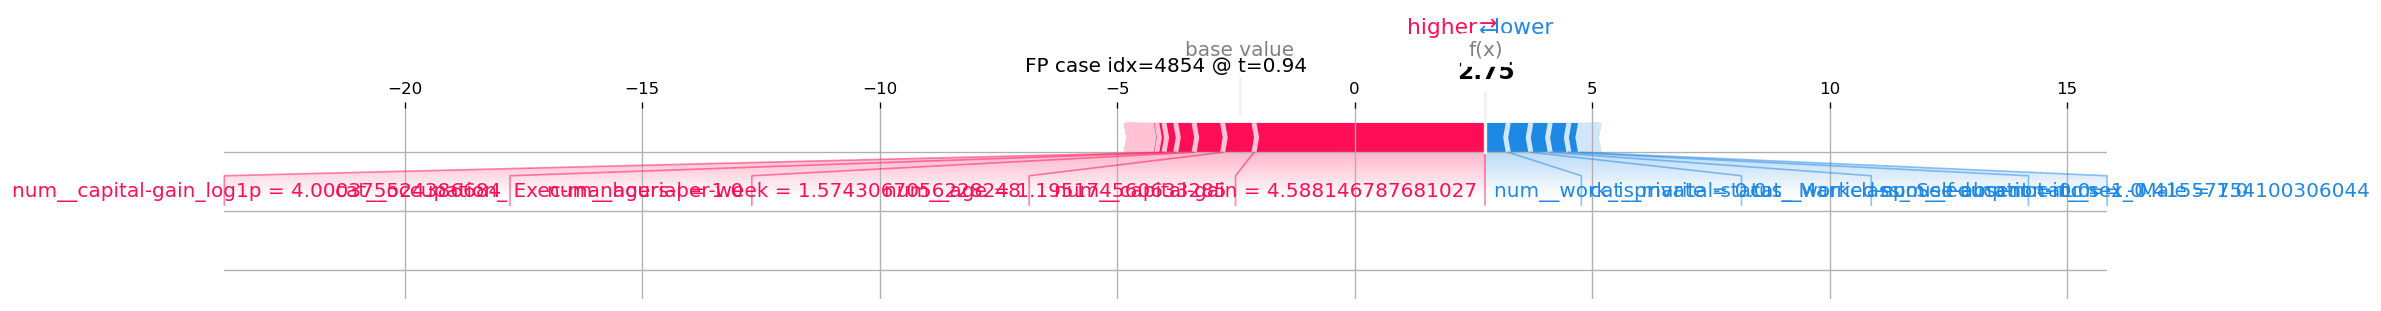

[warn] row idx=1233: добавлены 1 нулевых столбцов (cur=115, exp=116).
[warn] feature_names короче (115) ncols=116. Дополняем f115..f115.


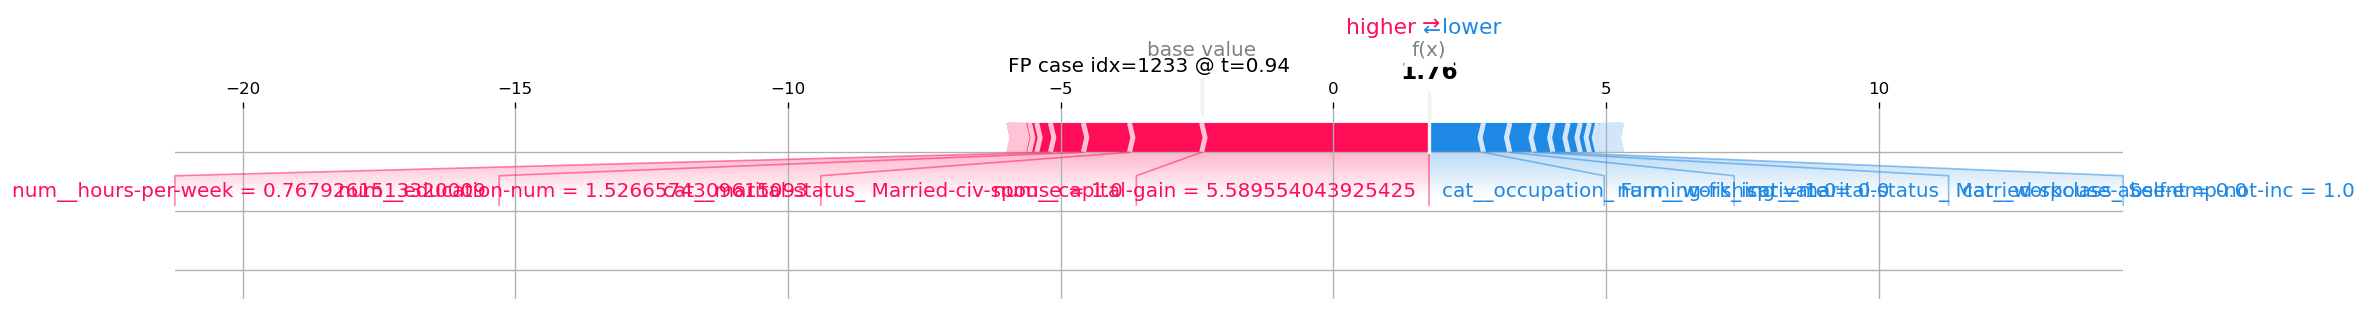

[warn] row idx=4850: добавлены 1 нулевых столбцов (cur=115, exp=116).
[warn] feature_names короче (115) ncols=116. Дополняем f115..f115.


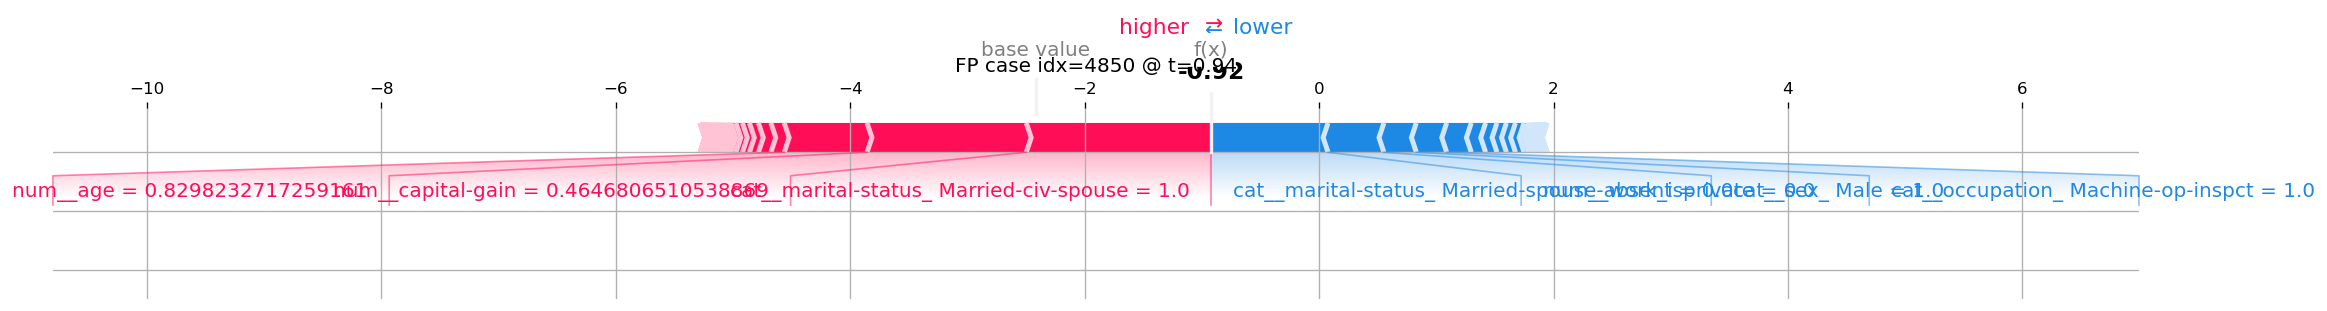

[warn] row idx=6363: добавлены 1 нулевых столбцов (cur=115, exp=116).
[warn] feature_names короче (115) ncols=116. Дополняем f115..f115.


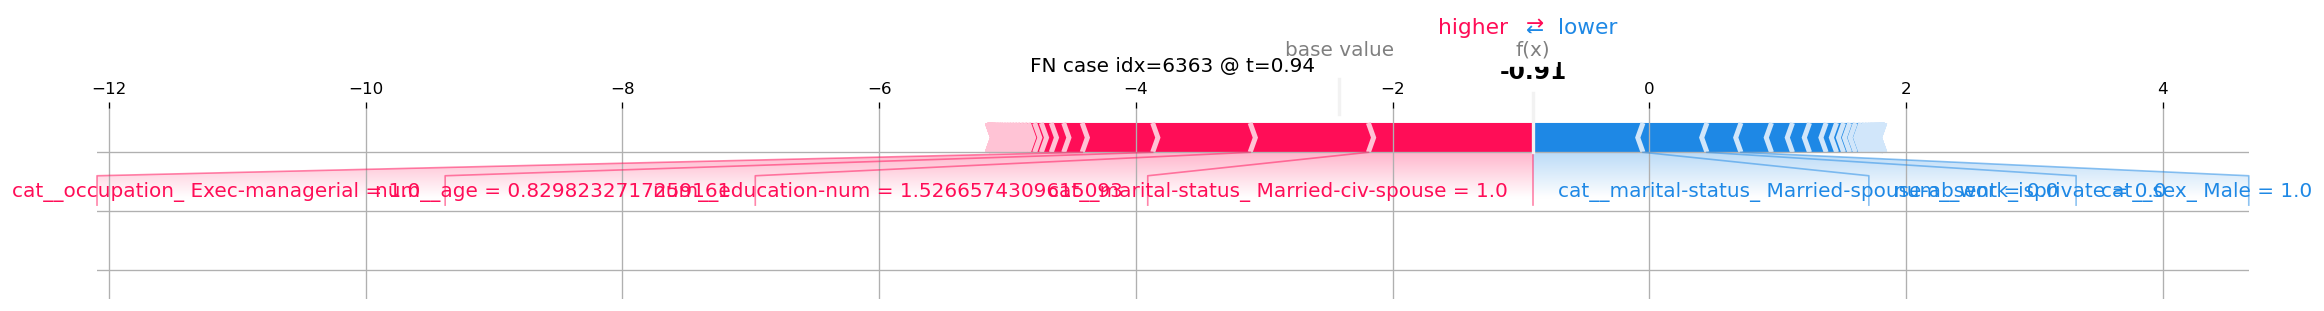

[warn] row idx=955: добавлены 1 нулевых столбцов (cur=115, exp=116).
[warn] feature_names короче (115) ncols=116. Дополняем f115..f115.


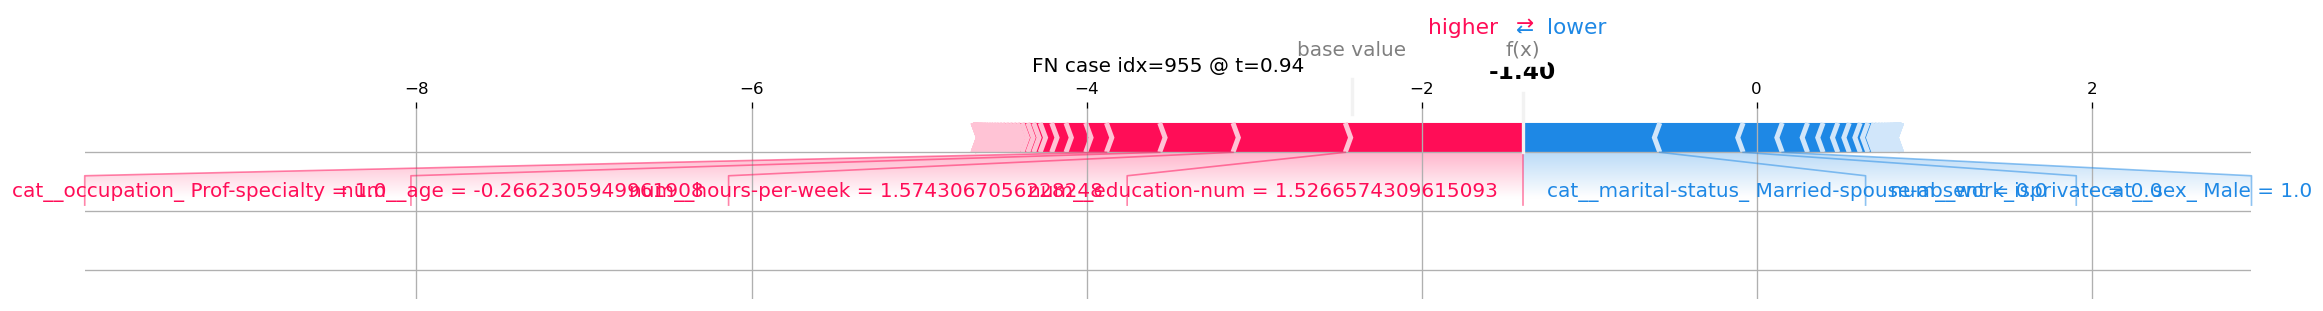

[warn] row idx=7615: добавлены 1 нулевых столбцов (cur=115, exp=116).
[warn] feature_names короче (115) ncols=116. Дополняем f115..f115.


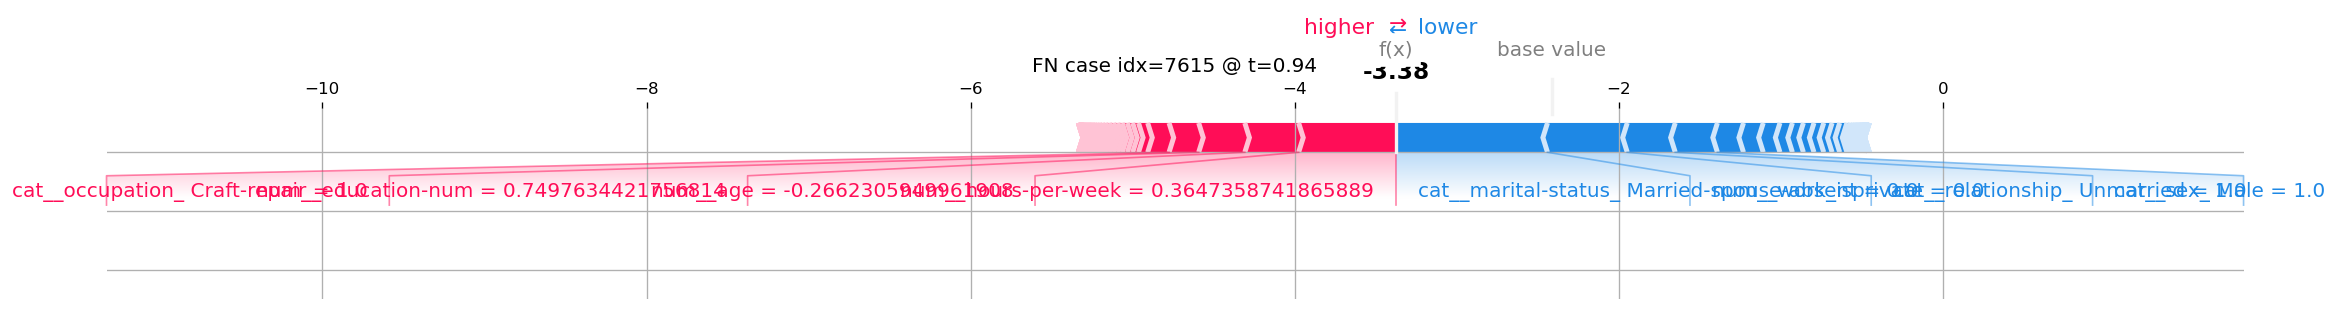

[debug] n_features: model=116, XS_full=115


In [29]:
# --- Explainability: локально (кейсы TP/FP/FN) --- #

ART_DIR = Path('data') / 'models'

thr = globals().get('t_star', 0.5)
y_pred_thr = (y_proba_best >= thr).astype('int8')

TP_idx = np.where((y_true_test == 1) & (y_pred_thr == 1))[0]
FP_idx = np.where((y_true_test == 0) & (y_pred_thr == 1))[0]
FN_idx = np.where((y_true_test == 1) & (y_pred_thr == 0))[0]

def _pick_some(arr, k=3):
    if len(arr) == 0:
        return []
    rng = np.random.default_rng(42)
    return arr if len(arr) <= k else rng.choice(arr, size=k, replace=False).tolist()

# модель #
clf = None
pipe = globals().get('pipe', None)

# если в памяти есть lgb_best - используем #
if 'lgb_best' in globals():
    clf = lgb_best

# иначе поиск pipeline/модели во всех типичных местах #
if clf is None:
    p_model = None
    # попытка сначала pipeline
    p_model = p_model or _first_exists_any(['LGBM_best.joblib', 'lgb_best.joblib'])

    if p_model is not None:
        obj = load(p_model)
        # это pipeline
        if hasattr(obj, 'named_steps'):
            pipe = obj
            clf = obj.named_steps.get('clf', obj)
        else:
            clf = obj



# берем X_test_enc и имена #
XS_full = None
if 'X_test_enc' in globals() and X_test_enc is not None:
    XS_full = X_test_enc

# имена фич: поддержка нескольких форматов (npy/txt/json/csv/parquet) #
feature_names = None
for nm in [
    'feature_names.npy', 'feature_names.txt', 'feature_names.json',
    'feature_names.csv', 'feature_names.parquet'
]:
    p_fn = _first_exists_any([nm])
    if p_fn is None:
        continue
    try:
        sfx = p_fn.suffix.lower()
        if sfx == '.npy':
            try:
                arr = np.load(p_fn, allow_pickle=False)
            except Exception:
                arr = np.load(p_fn, allow_pickle=True)
            feature_names = list(map(str, np.asarray(arr).ravel().tolist()))
        elif sfx == '.txt':
            with open(p_fn, 'r', encoding='utf-8') as f:
                feature_names = [line.strip() for line in f if line.strip() != '']
        elif sfx == '.json':
            import json
            with open(p_fn, 'r', encoding='utf-8') as f:
                obj = json.load(f)
            if isinstance(obj, list):
                feature_names = [str(x) for x in obj]
            elif isinstance(obj, dict):
                for k in ['feature_names', 'columns', 'names']:
                    if k in obj and isinstance(obj[k], list):
                        feature_names = [str(x) for x in obj[k]]
                        break
        elif sfx == '.csv':
            df_cols = pd.read_csv(p_fn)
            feature_names = df_cols.iloc[:, 0].astype(str).tolist() if df_cols.shape[1] == 1 else df_cols.columns.astype(str).tolist()
        elif sfx == '.parquet':
            df_cols = pd.read_parquet(p_fn)
            feature_names = df_cols.columns.astype(str).tolist()
    except Exception:
        feature_names = None
    if feature_names:
        break

# загрузка X_test_enc с диска #
def _expected_n_features_model(m):
    if m is None:
        return None
    if hasattr(m, 'n_features_in_'):
        try:
            return int(m.n_features_in_)
        except Exception:
            pass
    if hasattr(m, 'booster_') and getattr(m, 'booster_', None) is not None:
        try:
            return int(m.booster_.num_feature())
        except Exception:
            pass
    return None

def _find_all_candidates(names):
    # поиск во всех типичных папках + на 3 уровнях вверх #
    dirs = [
        Path('data')/'artifacts', Path('data')/'models',
        Path('notebooks')/'artifacts', Path('notebooks')/'models',
    ]
    roots = [Path('.').resolve()]
    roots += list(roots[0].parents)[:3]
    names_l = [n.lower() for n in names]
    seen, out = set(), []
    for d in dirs:
        if d.exists():
            for p in d.iterdir():
                if p.is_file() and p.name.lower() in names_l:
                    rp = str(p.resolve())
                    if rp not in seen:
                        seen.add(rp); out.append(p)
    for r in roots:
        for p in r.rglob('*'):
            try:
                if p.is_file() and p.name.lower() in names_l:
                    rp = str(p.resolve())
                    if rp not in seen:
                        seen.add(rp); out.append(p)
            except PermissionError:
                continue
    return out

if XS_full is None:
    exp_n = _expected_n_features_model(clf)
    candidates = _find_all_candidates([
        'X_test_enc.npz', 'X_test_enc.parquet', 'X_test_enc.npy'
    ])
    matched, first_loaded = None, None
    found_shapes = []
    for p in candidates:
        try:
            if p.suffix == '.npz':
                X_tmp = sp.load_npz(p)
            elif p.suffix == '.parquet':
                X_tmp = pd.read_parquet(p)
            elif p.suffix == '.npy':
                try:
                    X_tmp = np.load(p, allow_pickle=False)
                except ValueError:
                    X_tmp = np.load(p, allow_pickle=True)
            else:
                continue
            ncols = X_tmp.shape[1] if hasattr(X_tmp, 'shape') and len(X_tmp.shape) == 2 else None
            found_shapes.append((str(p), ncols))
            if first_loaded is None:
                first_loaded = X_tmp
            if (exp_n is not None) and (ncols == exp_n):
                matched = X_tmp
                print(f'[info] Используем X_test_enc, совпадающий с моделью: {p}')
                break
        except Exception:
            continue
    XS_full = matched if matched is not None else first_loaded
    if (matched is None) and (exp_n is not None) and (XS_full is not None):
            print(f'[warn] Совпадающий по ширине кэш не найден. '
                  f'Ширина модели: {exp_n}; найденные кэши: {found_shapes}')

# гарант корректной длины имен перед сборкой DataFrame #
def _ensure_len(cols, n):
    lst = list(cols) if isinstance(cols, (list, np.ndarray, pd.Index)) else []
    if len(lst) == n:
        return [str(c) for c in lst]
    if len(lst) > n:
        print(f'[warn] feature_names длиннее {len(lst)} ncols={n}. Обрезаем.')
        return [str(c) for c in lst[:n]]
    print(f'[warn] feature_names короче ({len(lst)}) ncols={n}. Дополняем f{len(lst)}..f{n-1}.')
    return [str(c) for c in (lst + [f'f{i}' for i in range(len(lst), n)])]

if XS_full is not None and not isinstance(XS_full, pd.DataFrame):
    ncols = XS_full.shape[1] if hasattr(XS_full, 'shape') and len(XS_full.shape) == 2 else None
    if ncols is not None:
        feature_names = _ensure_len(feature_names, ncols)
    if sp.issparse(XS_full):
        XS_full = pd.DataFrame.sparse.from_spmatrix(
            XS_full, columns=feature_names if feature_names is not None else None
        )
    else:
        XS_full = pd.DataFrame(
            XS_full, columns=feature_names if feature_names is not None else None
        )

# выбор классификатора для SHAP #
clf_for_shap = None

def _extract_model(obj):
    if obj is None:
        return None
    if hasattr(obj, 'predict_proba') or hasattr(obj, 'predict'):
        return obj
    if hasattr(obj, 'named_steps'):
        steps = getattr(obj, 'named_steps', {})
        mdl = steps.get('clf', None)
        if mdl is None:
            for _, s in steps.items():
                if hasattr(s, 'predict_proba') or hasattr(s, 'predict'):
                    mdl = s
                    break
        return mdl
    return None

clf_for_shap = _extract_model(clf) or _extract_model(pipe)

# основной цикл по кейсам #
if clf_for_shap is None or XS_full is None:
    print('Нет пригодной модели/данных для локальных SHAP-кейсов - пропуск блока.')
else:
    expl = shap.TreeExplainer(clf_for_shap)

    cases = [
        ('TP', _pick_some(TP_idx, 3)),
        ('FP', _pick_some(FP_idx, 3)),
        ('FN', _pick_some(FN_idx, 3)),
    ]
    for tag, idxs in cases:
        if not idxs:
            print(f'{tag}: нет кейсов - пропуск.')
            continue
        for i in idxs:
            row2d = XS_full.iloc[[i]] if hasattr(XS_full, 'iloc') else XS_full[i:i+1]
            # подготовка входа точно такой формы, как ждет модель
            exp_n = _expected_n_features_model(clf_for_shap)
            X_for_shap = None

            # если DataFrame со sparse-столбцами - в CSR напрямую (чтобы LGBM не 'передумывал' тип)
            try:
                from pandas.api.types import is_sparse_dtype
                has_sparse = hasattr(row2d, 'dtypes') and any(is_sparse_dtype(dt) for dt in row2d.dtypes)
            except Exception:
                has_sparse = False
            
            if has_sparse and hasattr(row2d, 'sparse'):
                X_for_shap = row2d.sparse.to_coo().tocsr()
            elif hasattr(row2d, 'to_numpy'):
                X_for_shap = row2d.to_numpy(dtype=np.float64, copy=False)
            else:
                X_for_shap = np.asarray(row2d, dtype=np.float64)
            
            # жесткое выравнивание числа столбцов
            if exp_n is not None and hasattr(X_for_shap, 'shape') and len(X_for_shap.shape) == 2:
                cur_n = X_for_shap.shape[1]
                if cur_n != exp_n:
                    # попытка альтернативной конверсии (если была dense - делаем CSR, и наоборот)
                    if sp.issparse(X_for_shap):
                        X_alt = np.asarray(row2d, dtype=np.float64) if hasattr(row2d, 'to_numpy') else np.asarray(row2d, dtype=np.float64)
                    else:
                        try:
                            X_alt = row2d.sparse.to_coo().tocsr()
                        except Exception:
                            X_alt = None
                    if X_alt is not None and hasattr(X_alt, 'shape') and len(X_alt.shape) == 2 and X_alt.shape[1] == exp_n:
                        X_for_shap = X_alt
                    else:
                        # последний рубеж: паддинг/обрезка по числу фич (для стабильного SHAP)
                        if cur_n < exp_n:
                            pad = np.zeros((X_for_shap.shape[0], exp_n - cur_n), dtype=X_for_shap.dtype)
                            X_for_shap = np.hstack([X_for_shap, pad]) if not sp.issparse(X_for_shap) else sp.hstack([X_for_shap, sp.csr_matrix(pad)], format='csr')
                            print(f'[warn] row idx={i}: добавлены {exp_n - cur_n} нулевых столбцов (cur={cur_n}, exp={exp_n}).')
                        elif cur_n > exp_n:
                            if sp.issparse(X_for_shap):
                                X_for_shap = X_for_shap[:, :exp_n]
                            else:
                                X_for_shap = X_for_shap[:, :exp_n]
                            print(f'[warn] row idx={i}: обрезаны {cur_n - exp_n} лишних столбцов (cur={cur_n}, exp={exp_n}).')
            # подсчет SHAP
            sv = expl.shap_values(X_for_shap)
            
            # бинарный класс -> вклад позитивного
            if isinstance(sv, list):
                try:
                    classes_ = getattr(clf_for_shap, 'classes_', [0, 1])
                    pos_idx = list(classes_).index(1)
                except Exception:
                    pos_idx = 1 if len(sv) > 1 else 0
                sv_class = sv[pos_idx]
            else:
                # fallback для доступа к expected_value
                pos_idx = 1
                sv_class = sv
            
            # приведение к 1D-вектору
            sv_vec = sv_class[0] if (getattr(sv_class, 'ndim', 1) == 2 and sv_class.shape[0] == 1) else sv_class

            nfeat = X_for_shap.shape[1] if hasattr(X_for_shap, 'shape') and len(X_for_shap.shape) == 2 else len(sv_vec)

            if len(sv_vec) == nfeat + 1:
                base_val = float(sv_vec[-1])
                sv_no_bias = sv_vec[:-1]
            else:
                base_val = (expl.expected_value[pos_idx]
                            if isinstance(expl.expected_value, list) else expl.expected_value)
                sv_no_bias = sv_vec

            if sp.issparse(X_for_shap):
                features_for_plot = np.asarray(X_for_shap.toarray()[0]).ravel()
            else:
                features_for_plot = np.asarray(X_for_shap[0]).ravel()

            # имена фич под ту же длину
            names_for_plot = _ensure_len(feature_names, nfeat) if feature_names is not None else None
            
            shap.force_plot(
                base_value=base_val,
                shap_values=sv_no_bias,
                features=features_for_plot,
                feature_names=names_for_plot,
                matplotlib=True,
                show=False
            )
            plt.title(f'{tag} case idx={i} @ t={thr:.2f}')
            plt.tight_layout(); plt.show()

print(f'[debug] n_features: model={_expected_n_features_model(clf_for_shap)}, XS_full={XS_full.shape[1]}')

# --- Риски, ограничения, рекомендации --- #

**Качество модели:**
1. Базовый порог t = 0.5: Accuracy ~0.878, F1 ~0.723, ROC-AUC ~0.89.
2. После оптимизации (ThresholdOptimizer DP) удалось сильно снизить разрыв по *'sex'* (dp_diff ~0.0012), но при этом немного просели F1/Accuracy.

**Справедливость:**
1. На базовом пороге t = 0.5 - значимый разрыв в selection rate (женщины в 3 раза реже получают положительный прогноз).
2. Пост-процессинг DP почти полностью выровнял группы, но с потерей качества.
3. EqOdds уменьшил разрыв по TPR/FPR, но не столь эффективно для общего dp_diff.

**Калибровка:**
1. Для больших групп (*'sex'*, *'White'*, *'26-45 лет'*) - отличная (ECE < 0.02).
2. Для малых групп (*'Other race'*, *'Amer-Indian-Eskimo'*, *'65+'*) - калибровка хуже, вероятности "рваные" из-за малого числа наблюдений.
3. Рекомендация: дополнительно проверить калибровку на валидации, возможно применить Platt/Isotonic для крупных групп.

**Интерпретируемость (SHAP):**
1. Важнейшие признаки: *'marital-status_Married-civ-spouse'*, *'age'*, *'education-num'*, *'capital-gain'*, *'hours-per-week'*.
2. Чувствительные признаки (*'sex'*, *'race'*, *'age_group'*) имеют малое среднее влияние - модель напрямую их почти не использует.
3. Но косвенное влияние (через *'marital-status'*, *'occupation'*) возможно.

**Риски и ограничения:**
1. Малые подгруппы -> нестабильные метрики, риски переобучения при перекалибровке.
2. Баланс fairness/accuracy: при сильной коррекции fairness (DP/EqOdds) качество заметно падает.
3. Возможные прокси-признаки (семейное положение, профессия) могут неявно кодировать пол/возраст.

**Рекомендации:**
1. Для продуктивного использования модель - оставлять *'t = 0.5'* или *'t*'* как базовый вариант.
2. Для задач, где fairness критичен - рассмотреть ThresholdOptimizer (DP).
3. Пересобрать фичи: убрать/агрегировать потенциальные прокси, проверить, как это влияет на fairness.
4. Дособрать данные по малым группам (особенно по расам и возрасту 65+).
5. Рассмотреть групповую калибровку для основных чувствительных переменных.

In [32]:
# --- Экспорт артефактов из 03_fairness_and_explainability.ipynb --- #

ART_DIR = globals().get('ART_DIR', Path('data') / 'models')
REPORTS_DIR = globals().get('REPORTS_DIR', Path('reports'))

ART_DIR.mkdir(parents=True, exist_ok=True)
(REPORTS_DIR / 'figures_03').mkdir(parents=True, exist_ok=True)

# экспорт сканирования порогов #
scan_obj = globals().get('scan_df', None)
try:
    if isinstance(scan_obj, pd.DataFrame) and len(scan_obj) > 0:
        out_csv = ART_DIR / 'fairness_threshold_scan.csv'
        scan_obj.to_csv(out_csv, index=False)
        print(f'Saved fairness_threshold_scan.csv -> {out_csv}')

        # копия в reports для удобства просмотра
        out_csv_rep = (REPORTS_DIR / 'figures_03' / 'fairness_threshold_scan.csv')
        try:
            scan_obj.to_csv(out_csv_rep, index=False)
            print(f'Copied to reports -> {out_csv_rep}')
        except Exception as e:
            print('[warn] copy to reports failed:', e)
    else:
        print('[info] scan_df отсутствует или пуст - экспорт пропущен.')
except Exception as e:
    print('[warn] scan_df export:', e)

print('Экспорт артефактов из 03_fairness_and_explainability.ipynb завершен.')

Saved fairness_threshold_scan.csv -> data\models\fairness_threshold_scan.csv
Copied to reports -> C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\fairness_threshold_scan.csv
Экспорт артефактов из 03_fairness_and_explainability.ipynb завершен.
